# Data Analysis of EPD, SPD, and EMS call logs for traffic violence.

Eugene Police Department and Springfield Police Department call are `grep`ed for:

* `Accident, Bike`
* `Accident, Vehicle-Bike`
* `Accident, Vehicle-Pedestrian`
* `Motor Vehicle Injury`
* `Motor Vehicle No Injury`
* `Motor Vehicle Unknown`

While Springfield-Eugene Fire/EMS call logs are `grep`ped for:

* `ACCIDENT ATV INJURY`
* `ACCIDENT BIKE`
* `ACCIDENT VEHICLE BIKE`
* `HIT AND RUN INJURY`
* `MOTOR VEH ACC FATALITY`
* `MOTOR VEH ACC INJURY`
* `MOTOR VEH ACC NO INJURY`
* `MOTOR VEH ACC UNKNOWN INJ`
* `MOTOR VEHICLE ACC W/HAZMAT`
* `TRAIN VS PED/BIKE CRASH`
* `TRAIN VS VEHICLE CRASH`
* `VEHICLE/PEDESTRIAN CRASH`



In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

In [2]:
def read_police_log(csv):
    return pd.read_csv(csv, parse_dates=True, dtype={'event_number': str, 'case': str})

epd = read_police_log('epd-traffic-violence.csv')
spd = read_police_log('spd-traffic-violence.csv')
ems = pd.read_csv('ems-traffic-violence.csv')

In [3]:
days_of_week = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def munge_generic(df, time_column):
    # We want our nominal years to end on the day of the last event.
    ts_latest_event = df[time_column].max()
    year_latest_event = ts_latest_event.year
    year_offset = ts_latest_event - datetime(year_latest_event, 1, 1) + timedelta(minutes=1)
    df[f"shifted_{time_column}_year"] = pd.DatetimeIndex(df[time_column]).map(lambda x: x - year_offset)
    df['year'] = pd.DatetimeIndex(df[f'shifted_{time_column}_year']).year
    df['year'] = df.year.astype('str')
    
    # we want our nominal day of week to end at 3 AM: Sunday morning at 1 AM is pretty much Saturday night for our purposes.
    df[f"shifted_{time_column}_dow"] = pd.DatetimeIndex(df[time_column]).map(lambda x: x - timedelta(hours=3))   
    
    dow_type = CategoricalDtype(categories=days_of_week, ordered=True)
    df['day_of_week'] = pd.DatetimeIndex(df[f'shifted_{time_column}_dow']).day_name()
    df['day_of_week'] = df['day_of_week'].astype(dow_type)

    df['day_of_year'] = pd.DatetimeIndex(df[f'shifted_{time_column}_dow']).day_of_year
    df['day_of_year'] = df['day_of_year'].map(lambda x: f"{x:03}")

    
  
    df['hour'] = pd.DatetimeIndex(df[time_column]).hour
    df['hour'] = df.hour.map(lambda x: f"{x:02}")

    months = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec' ]
    month_type = CategoricalDtype(categories=months, ordered=True)
    df['month'] = pd.DatetimeIndex(df[time_column]).month_name()
    df['month'] = df.month.map(lambda x: x[:3])
    df['month'] = df['month'].astype(month_type)

    df['month_n'] = pd.DatetimeIndex(df[time_column]).month.map(lambda x: f'{x:02}')
    df['day'] = pd.DatetimeIndex(df[time_column]).day.map(lambda x: f'{x:02}')

    
    df['date'] = df.year + df.month_n + df.day


    # discard the oldest year, as it will be incomplete
    oldest = df['year'].min()
    df = df[df['year'] != oldest]
    

def munge_police(df):
    df.call_time = pd.to_datetime(df.call_time, format='%m/%d/%Y %I:%M:%S %p')
    df.dispatch_time = pd.to_datetime(df.dispatch_time, format='%m/%d/%Y %I:%M:%S %p')
    
    df['description'] = df.incident_desc.map(lambda x: x.replace('Accident, ', ''))
    df['disposition'] = df.disposition.fillna('NOT RECORDED')



    munge_generic(df, 'call_time')

    for column in ['incident_desc', 'disposition', 'priority', 'year', 'day_of_year', 'hour']:
        df[column] = df[column].astype('category')
    
def munge_ems(df):
    df.dispatch_time = pd.to_datetime(df.dispatch_datetime, format='ISO8601')
    munge_generic(df, 'dispatch_time')

    for column in ['agency', 'area', 'city', 'description', 'year', 'day_of_year', 'hour']:
        df[column] = df[column].astype('category')
     
munge_police(epd)
munge_police(spd)
munge_ems(ems)

In [4]:
epd

,call_time,dispatch_time,incident_desc,disposition,event_number,location,priority,case,description,shifted_call_time_year,year,shifted_call_time_dow,day_of_week,day_of_year,hour,month,month_n,day,date
0,2020-08-09 09:59:39,2020-08-09 10:00:17,Motor Vehicle Injury,INFORMATION ONLY,20197826,"WILLAMETTE ST/E 7TH AVE, EUG",1,NaN,Motor Vehicle Injury,2020-08-07 06:30:56,2020,2020-08-09 06:59:39,Sunday,222,09,Aug,08,09,20200809
1,2020-08-06 02:25:05,2020-08-06 02:27:43,Motor Vehicle Unknown,REPORT TAKEN,20194859,"730-BLK W 11TH AVE, EUG",1,2012842,Motor Vehicle Unknown,2020-08-03 22:56:22,2020,2020-08-05 23:25:05,Wednesday,218,02,Aug,08,06,20200806
2,2020-08-26 21:10:41,2020-08-26 21:18:48,Motor Vehicle Unknown,ASSISTED,20214638,"BLAIR BLVD/W 7TH AVE, EUG",1,NaN,Motor Vehicle Unknown,2020-08-24 17:41:58,2020,2020-08-26 18:10:41,Wednesday,239,21,Aug,08,26,20200826
3,2020-08-26 18:21:40,2020-08-26 18:33:07,Motor Vehicle No Injury,INFORMATION ONLY,20214516,"N TERRY ST/DONOHOE AVE, EUG",1,NaN,Motor Vehicle No Injury,2020-08-24 14:52:57,2020,2020-08-26 15:21:40,Wednesday,239,18,Aug,08,26,20200826
4,2020-08-26 11:18:07,2020-08-26 11:19:34,Motor Vehicle Unknown,ASSISTED,20214099,"2650 RIVER RD, EUG",1,NaN,Motor Vehicle Unknown,2020-08-24 07:49:24,2020,2020-08-26 08:18:07,Wednesday,239,11,Aug,08,26,20200826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17484,2023-09-26 16:00:15,2023-09-26 16:01:55,"Accident, Vehicle-Pedestrian",REPORT TAKEN,23263095,"E 10TH AVE/PEARL ST, EUG",1,2314436,Vehicle-Pedestrian,2023-09-24 12:31:32,2023,2023-09-26 13:00:15,Tuesday,269,16,Sep,09,26,20230926
17485,2023-09-30 17:42:33,2023-09-30 17:42:34,Motor Vehicle Unknown,REPORT TAKEN,23267195,"COBURG RD/HARLOW RD, EUG",1,2314673,Motor Vehicle Unknown,2023-09-28 14:13:50,2023,2023-09-30 14:42:33,Saturday,273,17,Sep,09,30,20230930
17486,2023-09-30 15:56:07,2023-09-30 15:56:38,Motor Vehicle Unknown,DISREGARD,23267112,"218 I105 WB, EUG",1,NaN,Motor Vehicle Unknown,2023-09-28 12:27:24,2023,2023-09-30 12:56:07,Saturday,273,15,Sep,09,30,20230930
17487,2023-09-30 12:55:11,2023-09-30 13:02:22,"Accident, Vehicle-Bike",NO INVESTIGATION,23266944,"W 18TH AVE/HAWKINS LN, EUG",1,NaN,Vehicle-Bike,2023-09-28 09:26:28,2023,2023-09-30 09:55:11,Saturday,273,12,Sep,09,30,20230930


In [7]:
police = {
    'epd': {
        "bike": epd[epd["description"] == 'Bike'],
        "vehicle_bike": epd[epd.description == 'Vehicle-Bike'],
        "vehicle_pedestrian": epd[epd.description == 'Vehicle-Pedestrian'],
        "vehicle": epd[epd.incident_desc.str.startswith("Motor Vehicle ")],
    },
    'spd': {
        "bike": spd[spd["description"] == 'Bike'],
        "vehicle_bike": spd[spd.description == 'Vehicle-Bike'],
        "vehicle_pedestrian": spd[spd.description == 'Vehicle-Pedestrian'],
        "vehicle": spd[spd.incident_desc.str.startswith("Motor Vehicle ")],
    }
}

agencies = police.copy()
agencies |= {
    'ems': {
        "bike": ems[ems["description"] == 'ACCIDENT BIKE'],
        "vehicle_bike": ems[ems.description == 'ACCIDENT VEHICLE BIKE'],
        "vehicle_pedestrian": ems[(ems.description == 'VEHICLE/PEDESTRIAN CRASH') | (ems.description == "HIT AND RUN INJURY")],
        "vehicle": ems[ems.description.str.startswith('MOTOR VEH') ]
    }
}

def humanize(title: str)-> str:
    tokens = title.split("_")
    return ' '.join(word.capitalize() for word in title.split("_"))

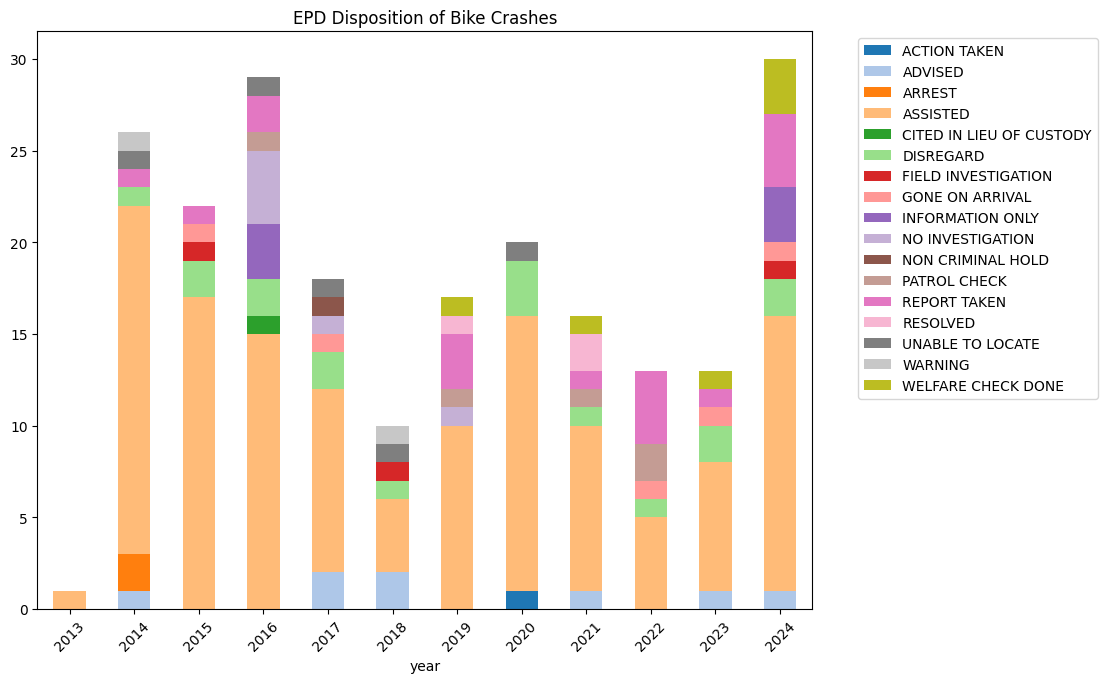

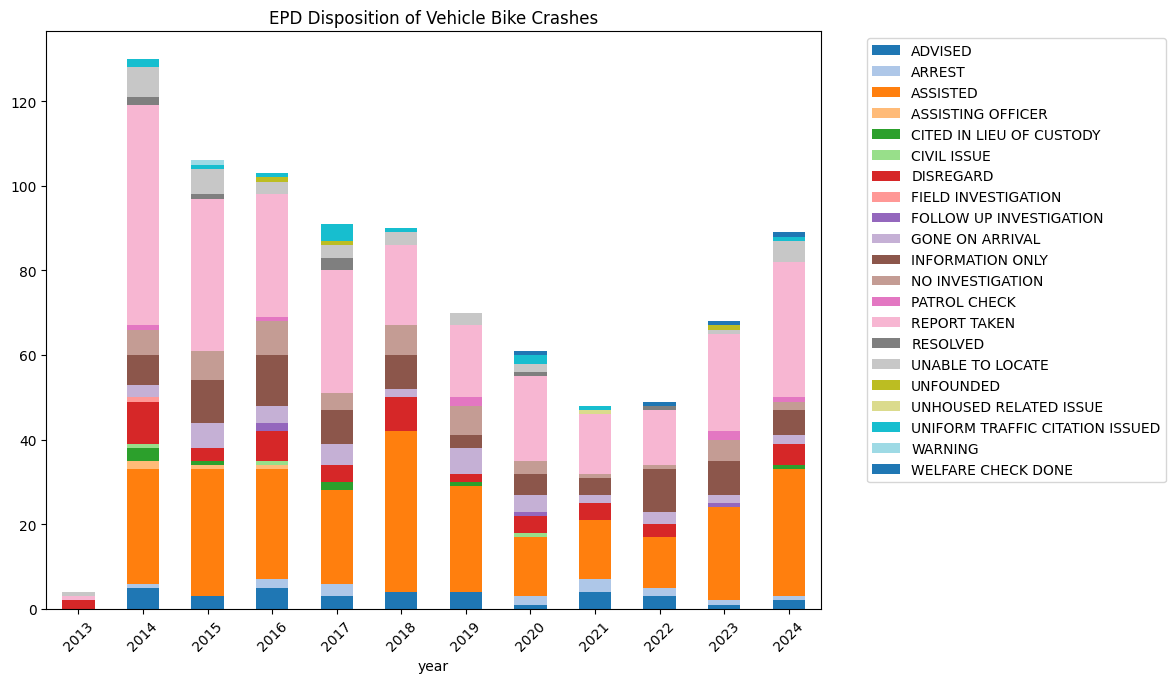

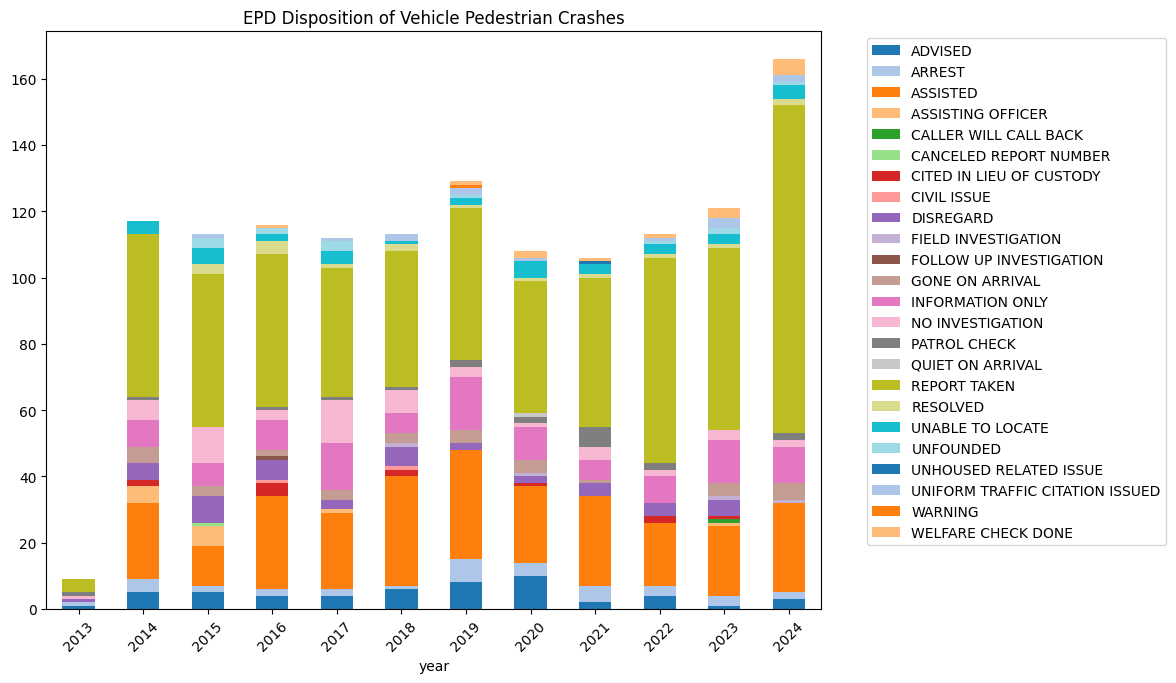

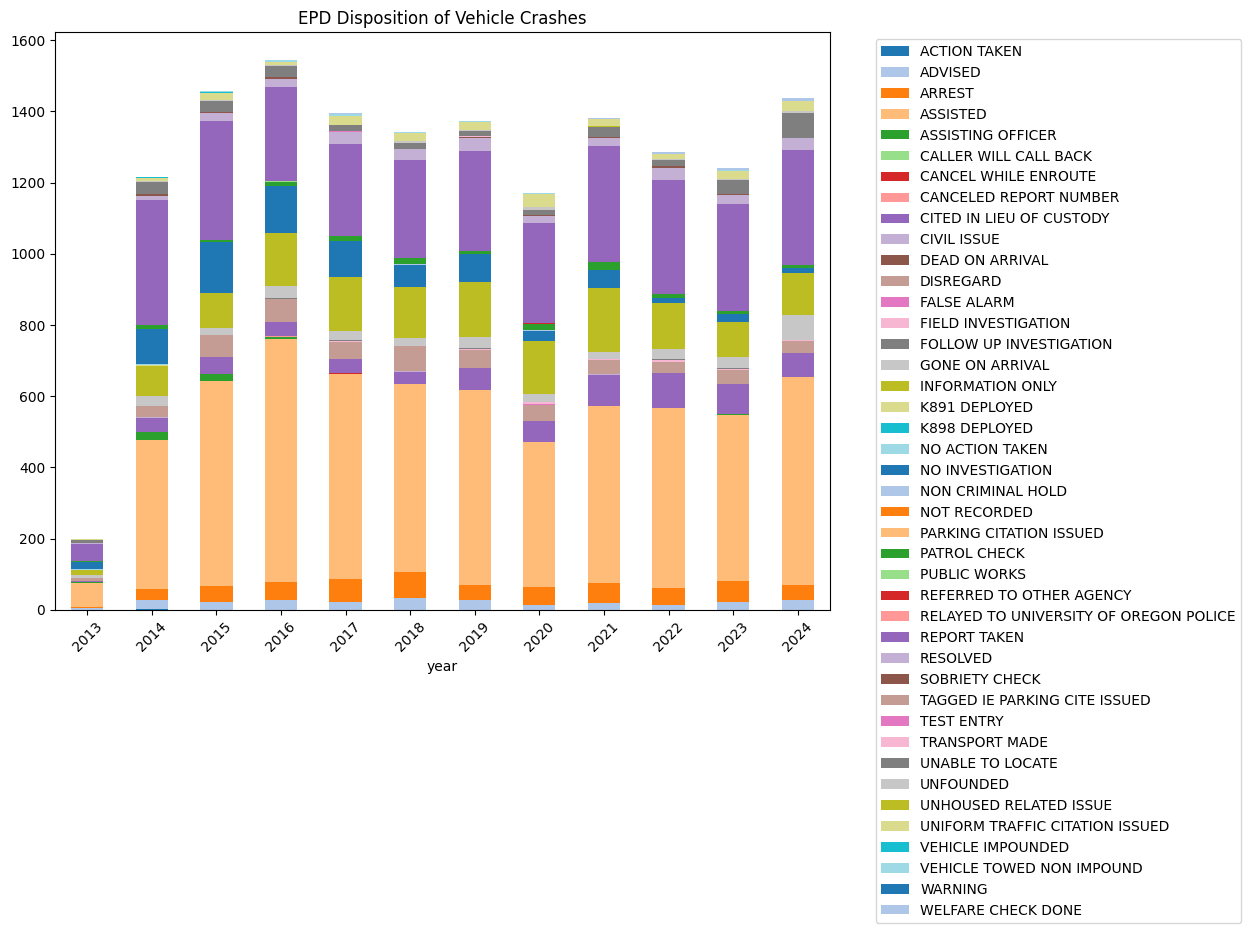

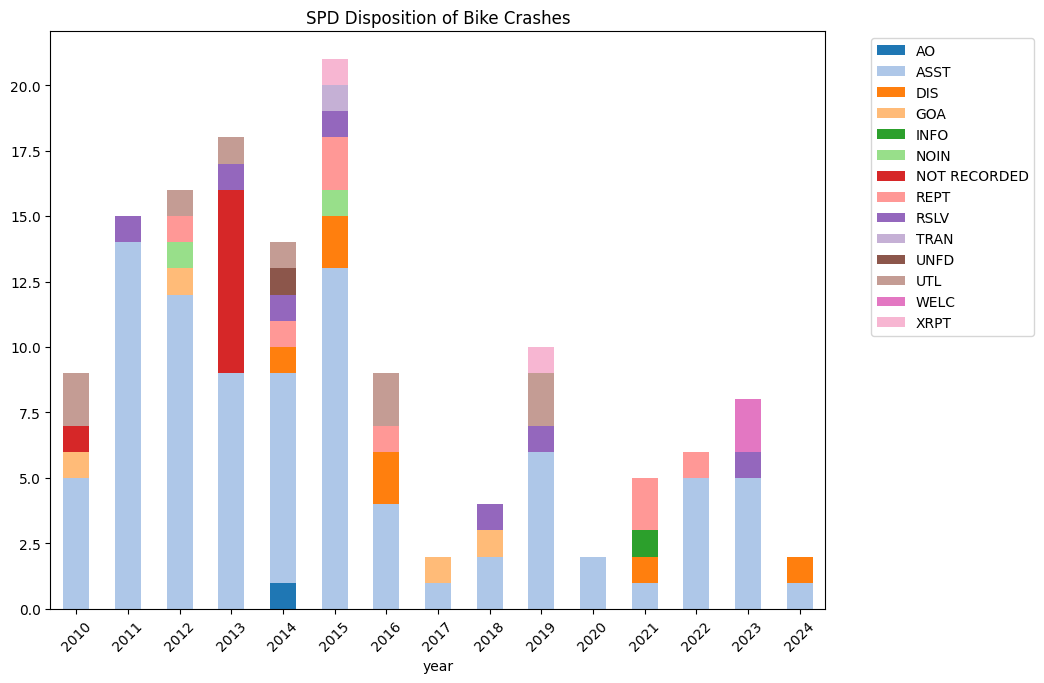

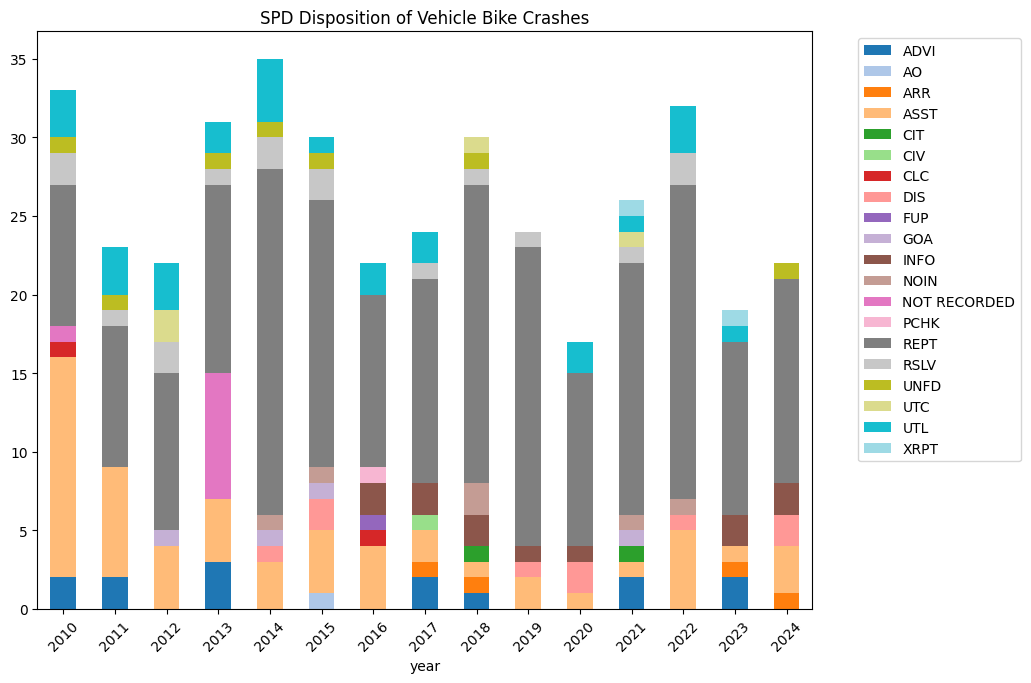

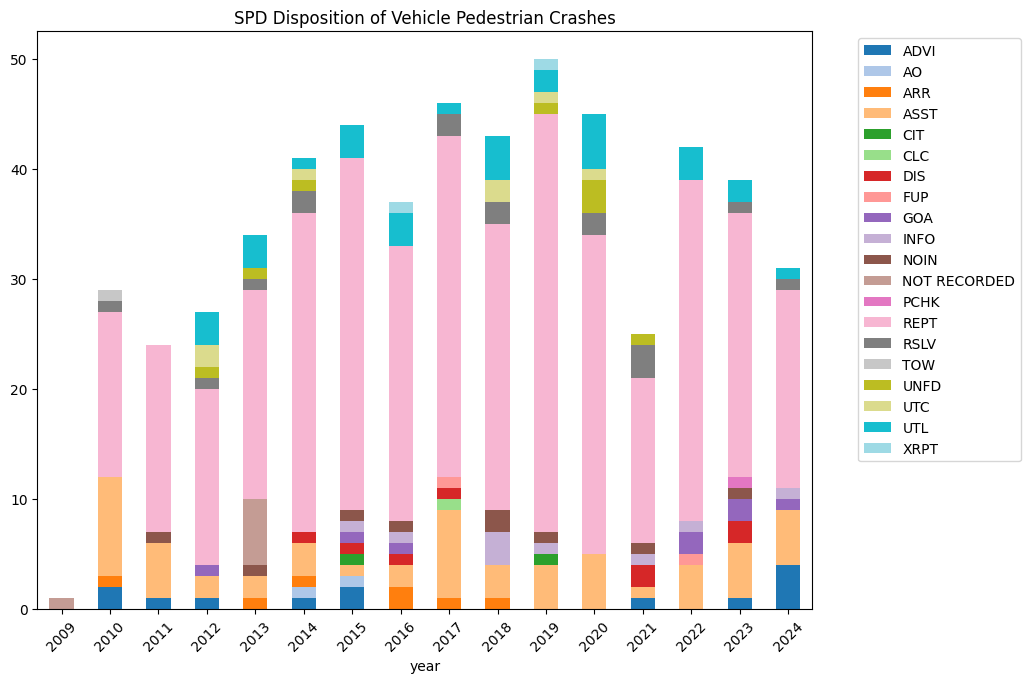

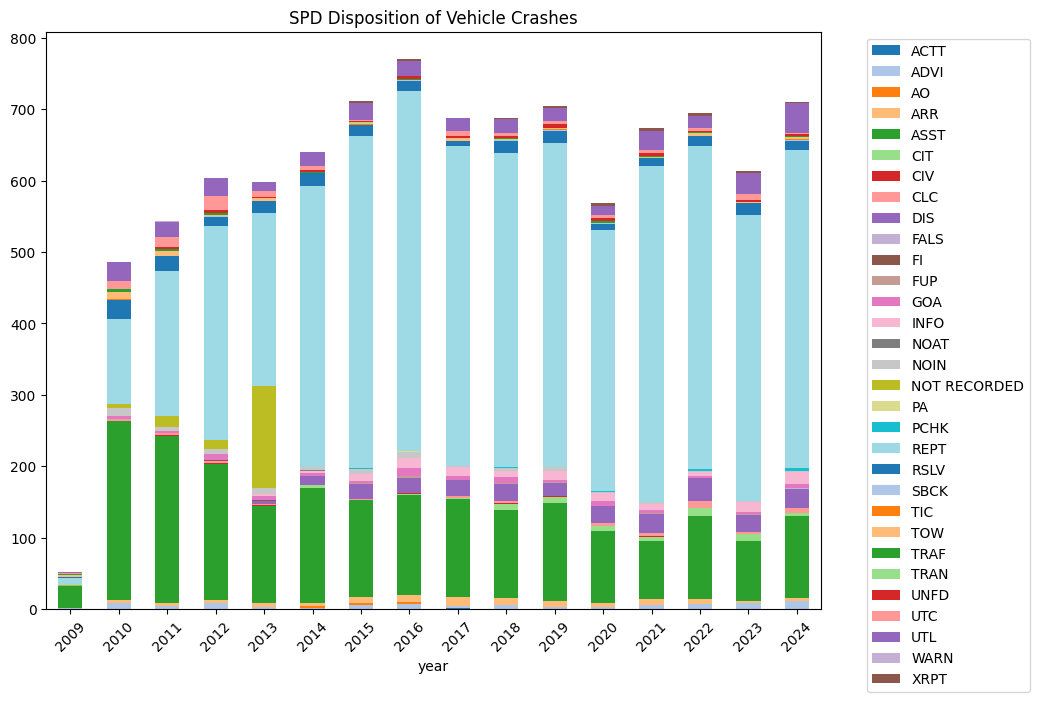

In [8]:
def plot_disposition_by_year(dataframe, agency=None, title=None):
    dispositions = dataframe.copy()[['year', 'disposition']].sort_values(['year', 'disposition'])
    dispositions['year'] = dispositions.year.map(str)
    dispositions.set_index('year')
    stacked = dispositions.groupby(['year', 'disposition'], observed=True).size()
    
    fig, ax = plt.subplots()

    stacked.unstack().plot(
        kind='bar',
        stacked=True,
        title=f'{agency.upper()} Disposition of {humanize(title)} Crashes',
        figsize=(10, 7.5),
        rot=45,
        ax=ax,
        color=plt.cm.tab20(np.linspace(0,1,20)),
    )

    legend = sorted(dispositions.disposition.unique())
     

for agency, logs in police.items():
    for crash_type, df in logs.items():
        plot_disposition_by_year(df, agency=agency, title=crash_type)

In [9]:
def plot_crashes_per_time_unit(dataframe, time_unit, rot=0, agency=None, title=None, kind='bar'):
    fix, ax = plt.subplots()
    grouped = dataframe.groupby(time_unit, observed=False)
    grouped.size().plot(
        kind=kind,
        stacked=True,
        title=f'{humanize(title)} Crashes by {humanize(time_unit)} per {agency.upper()} dispatch logs',
        #style="fivethirtyeight",
        figsize=(11,6),
        xlabel='',
        rot=rot,
    )

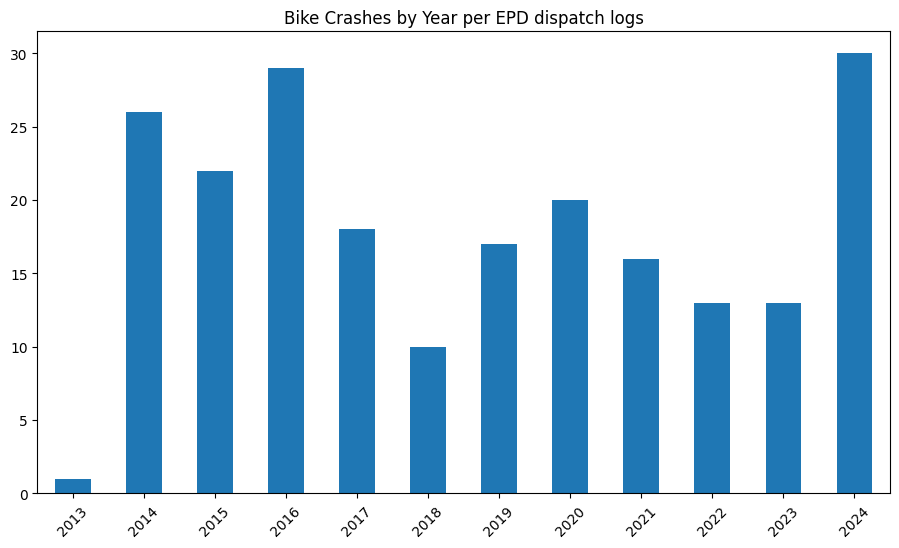

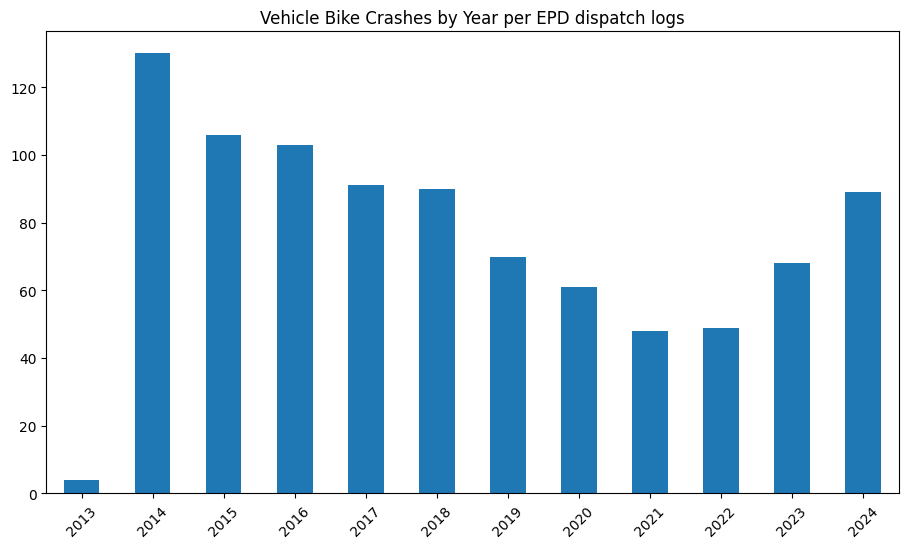

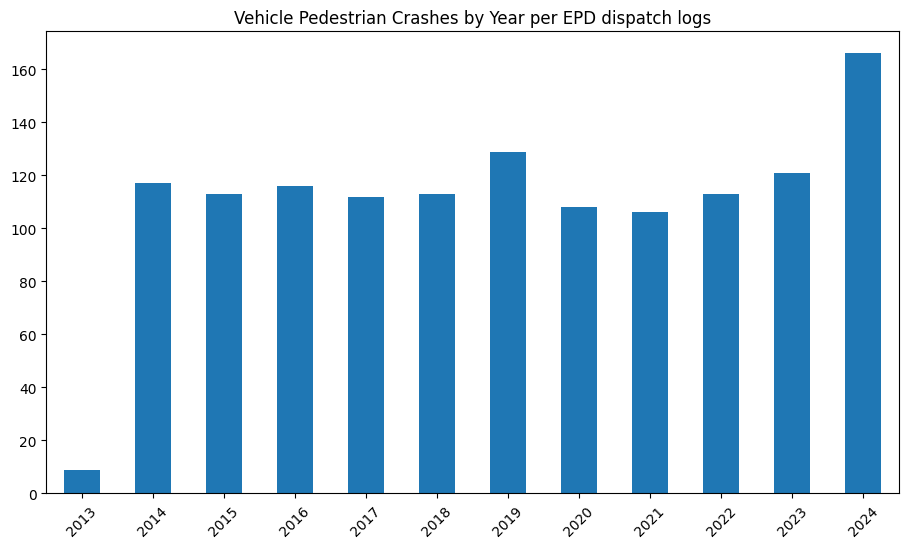

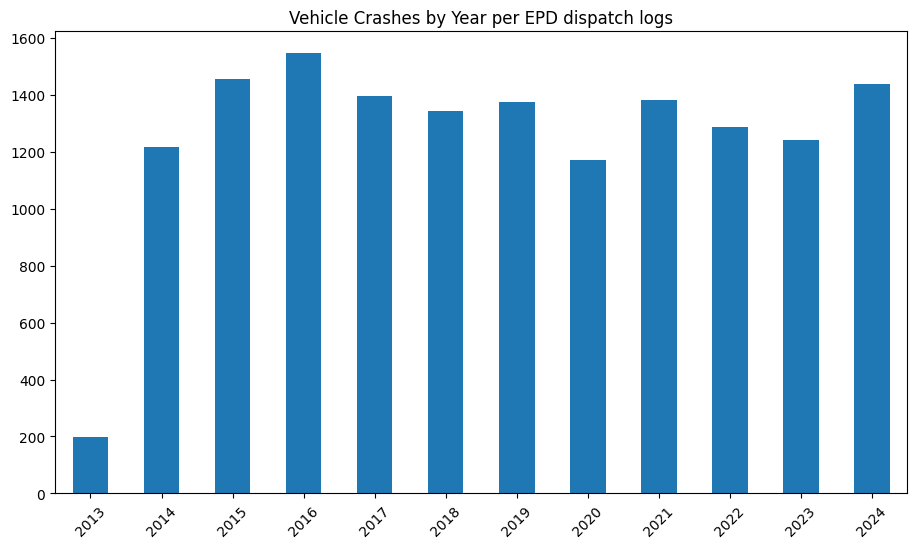

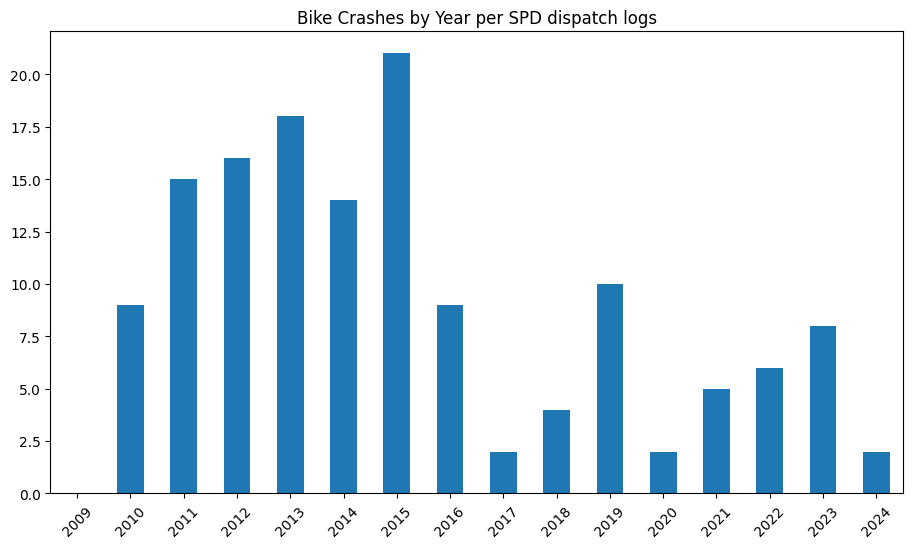

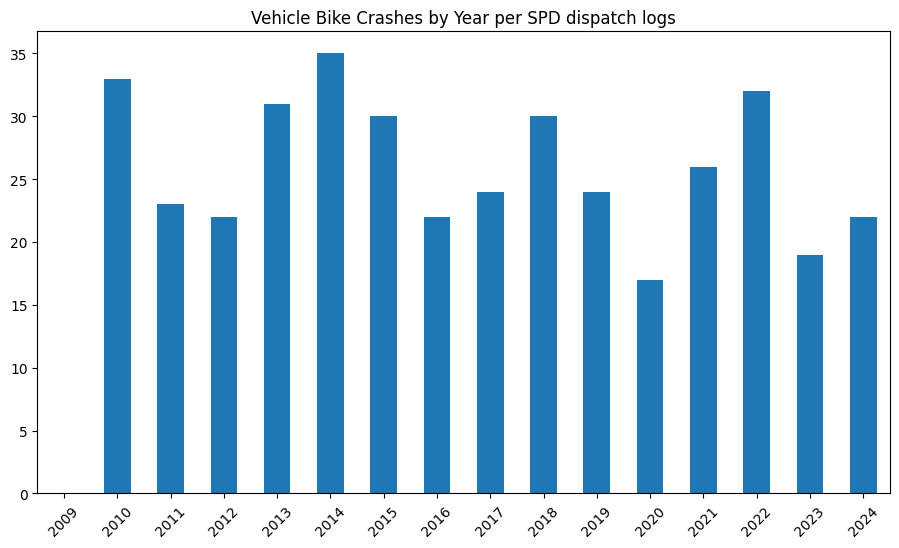

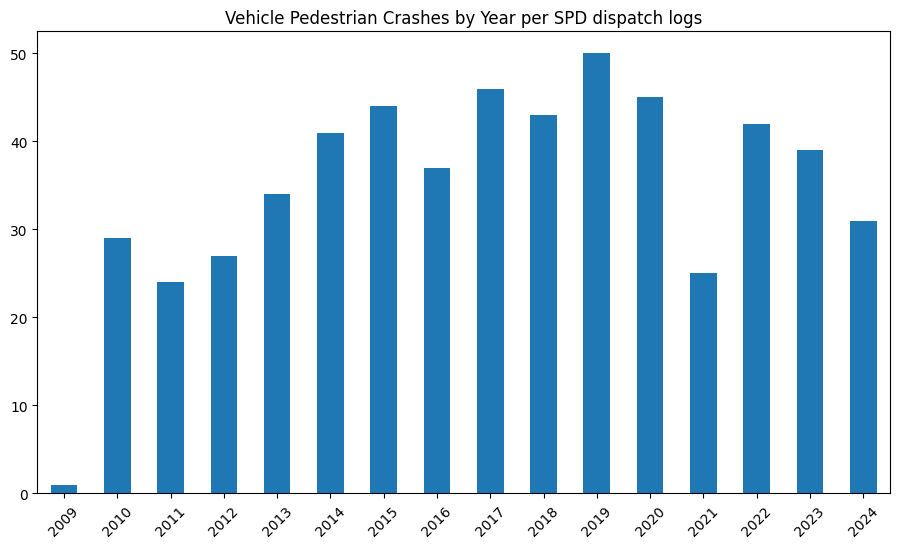

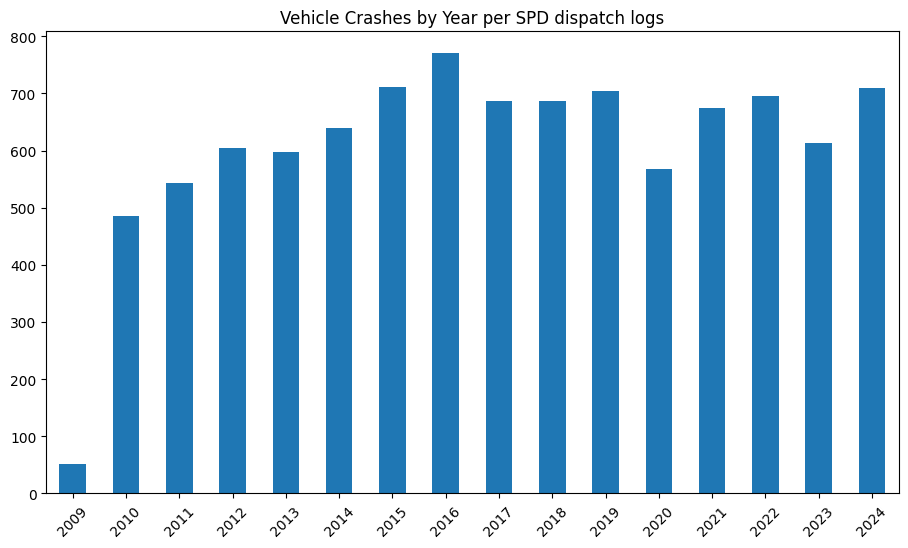

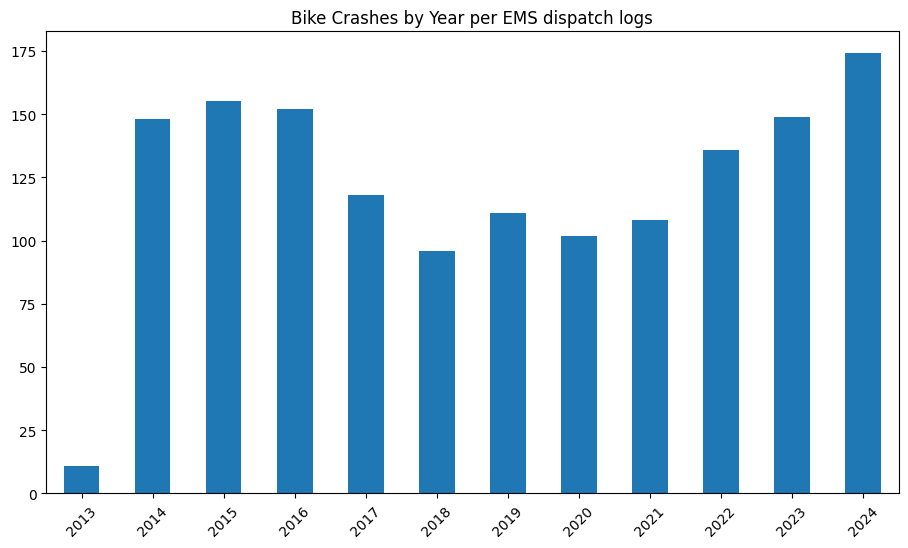

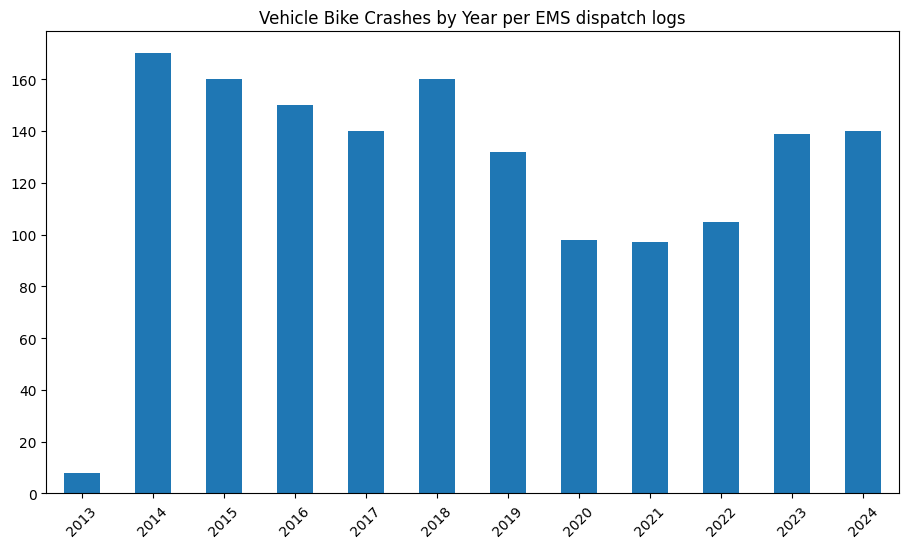

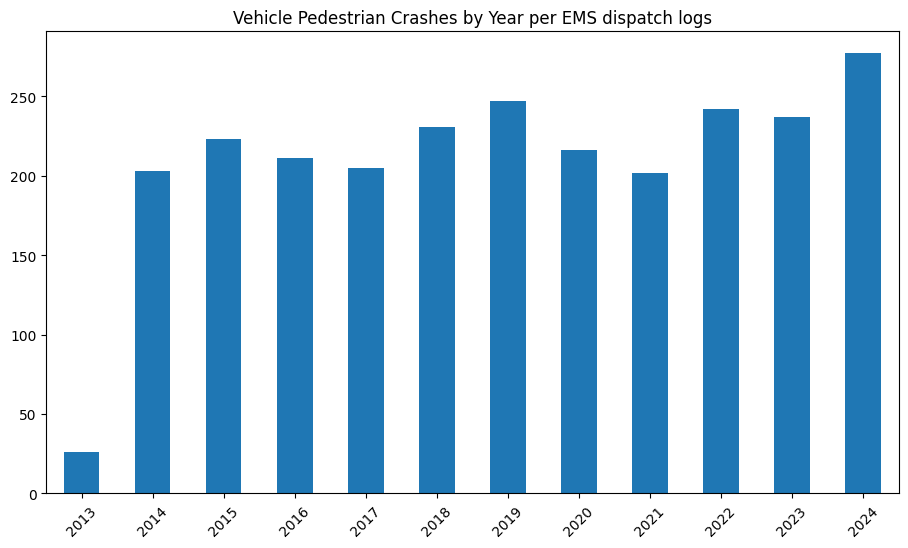

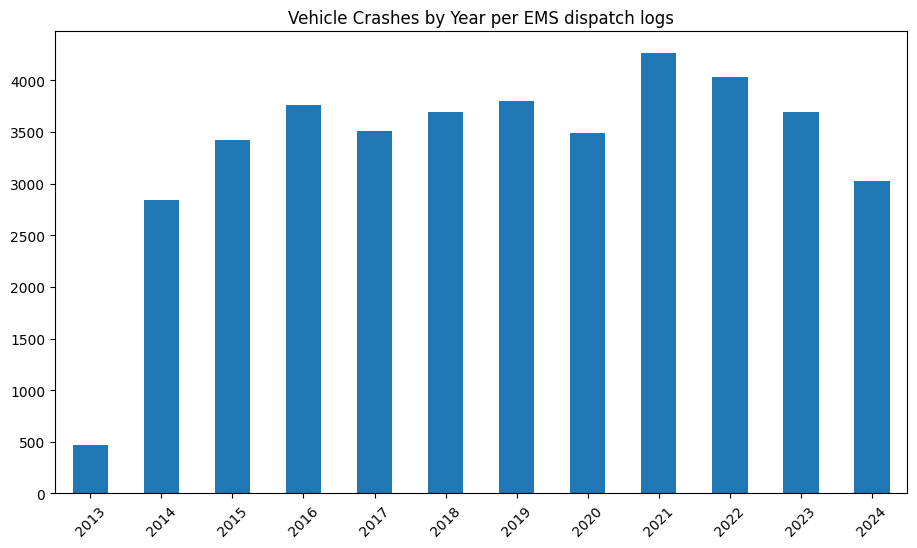

In [10]:
for agency, logs in agencies.items():
    for crash_type, df in logs.items():
        plot_crashes_per_time_unit(df, "year", agency=agency, title=crash_type, rot=45)

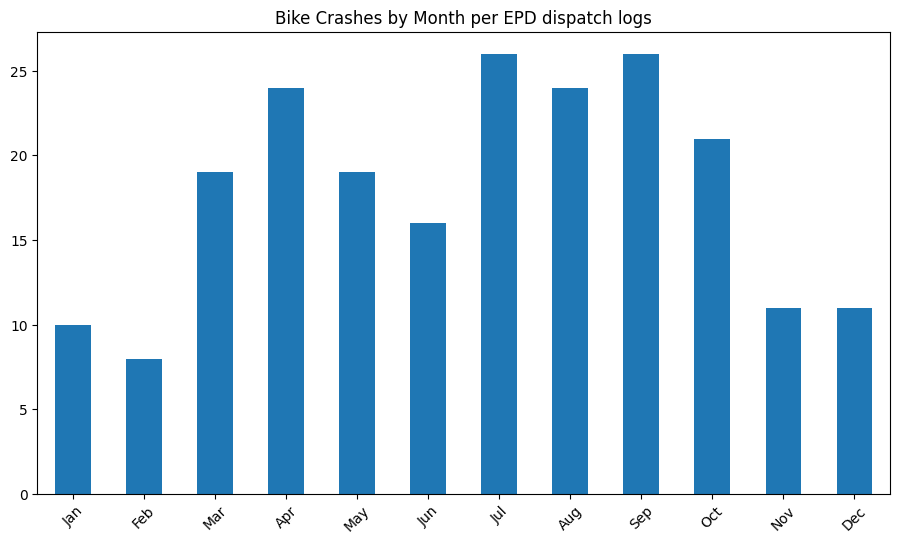

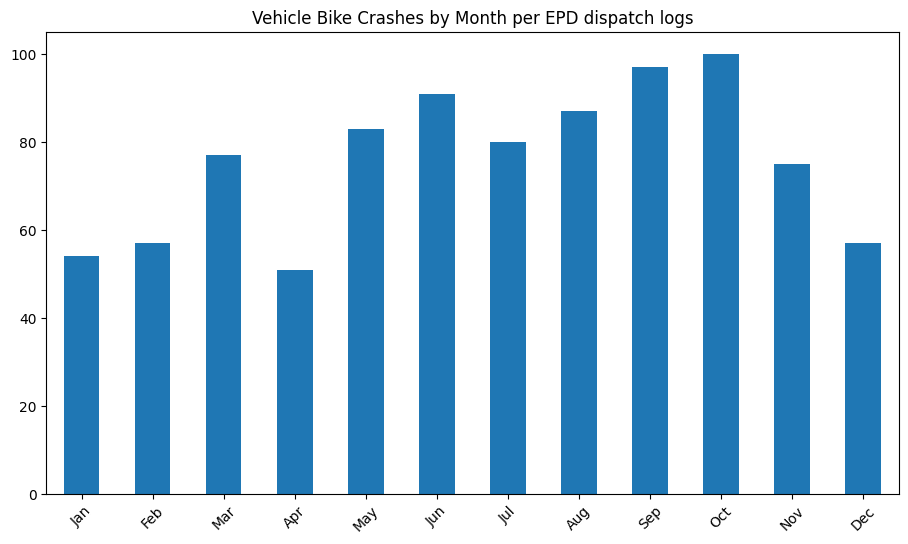

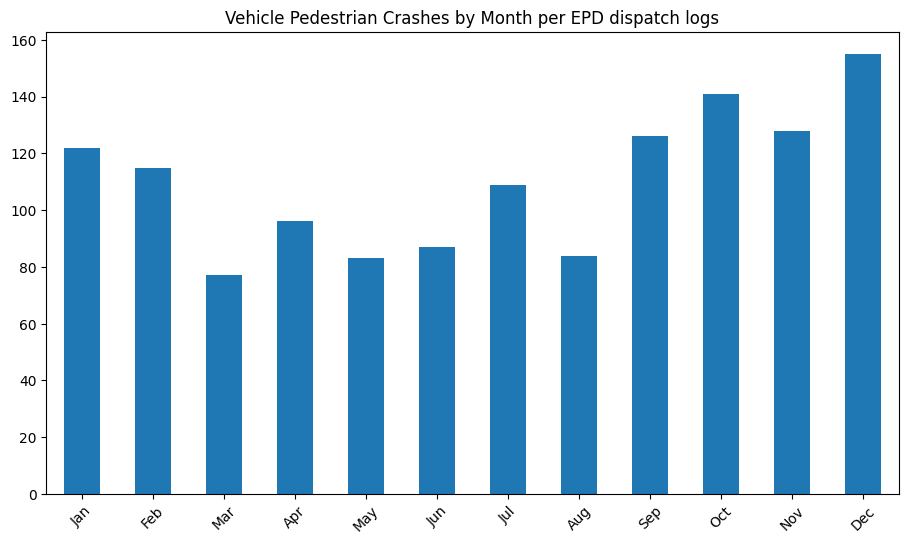

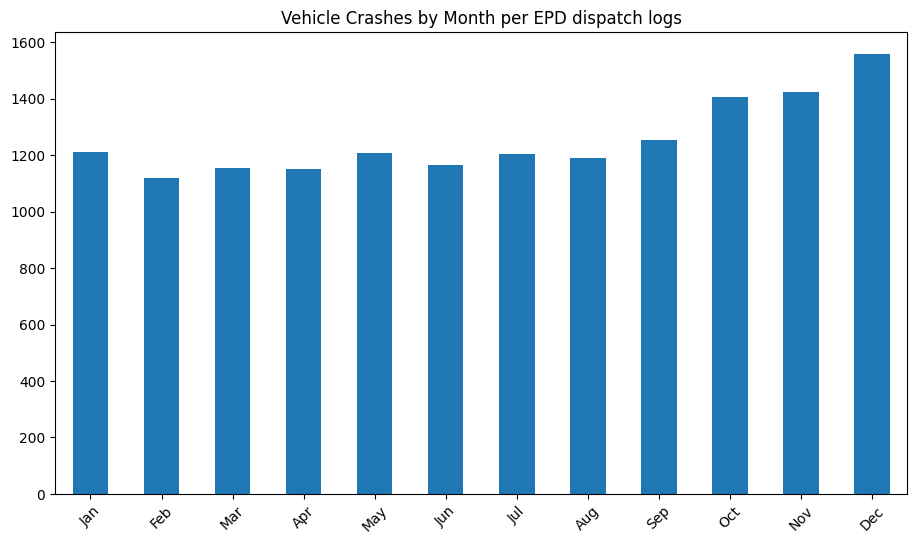

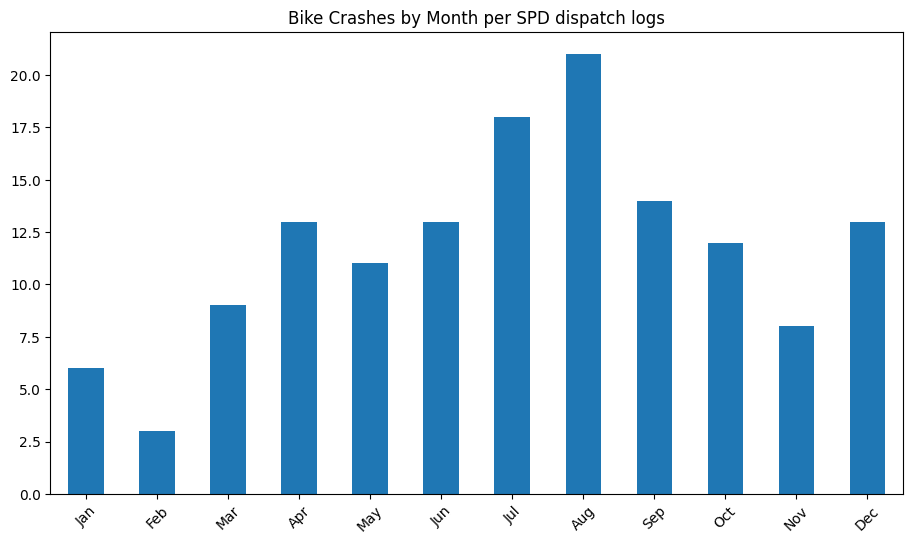

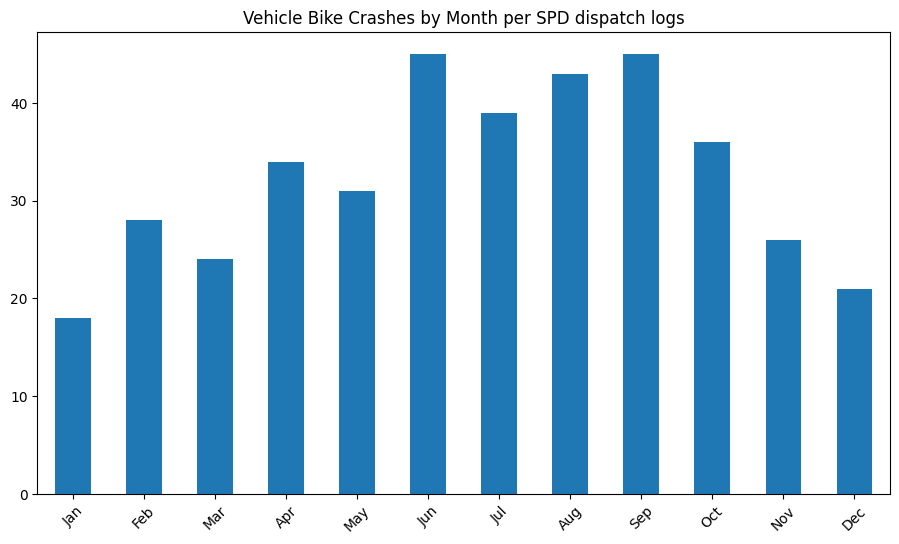

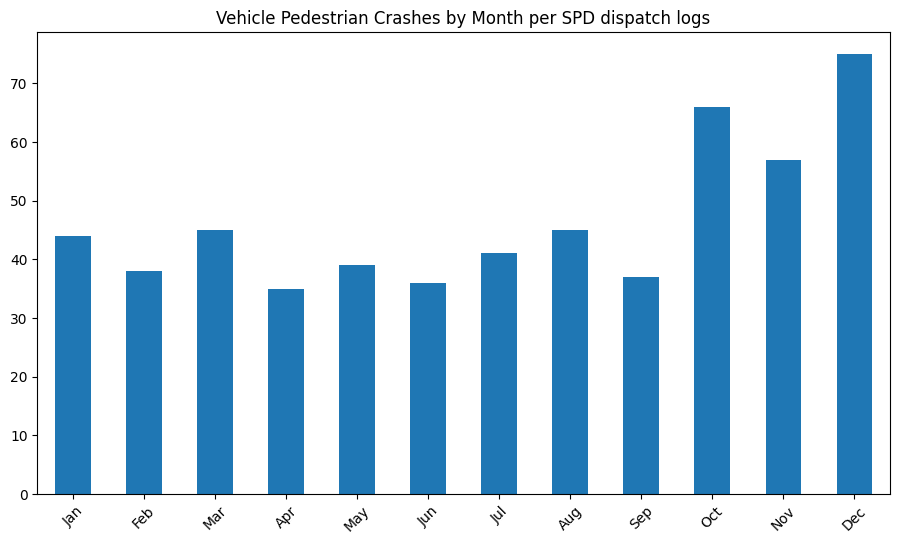

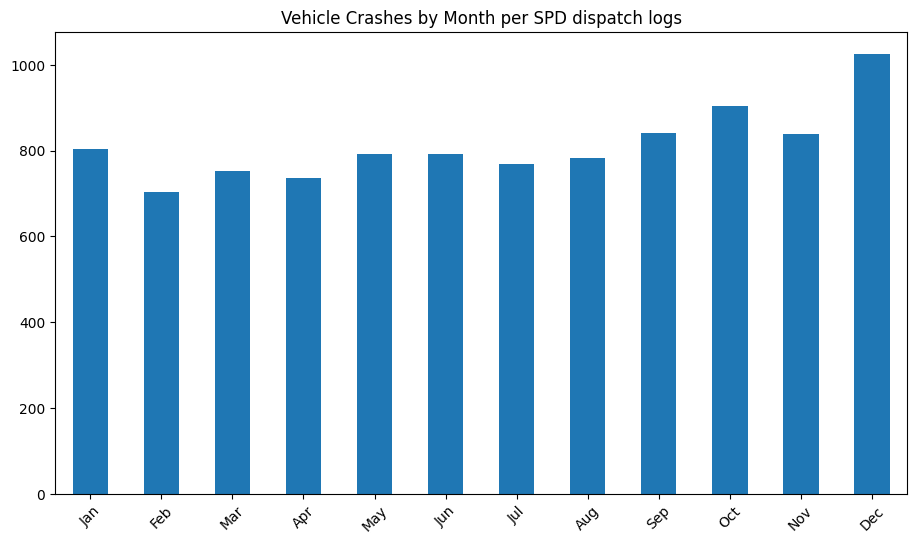

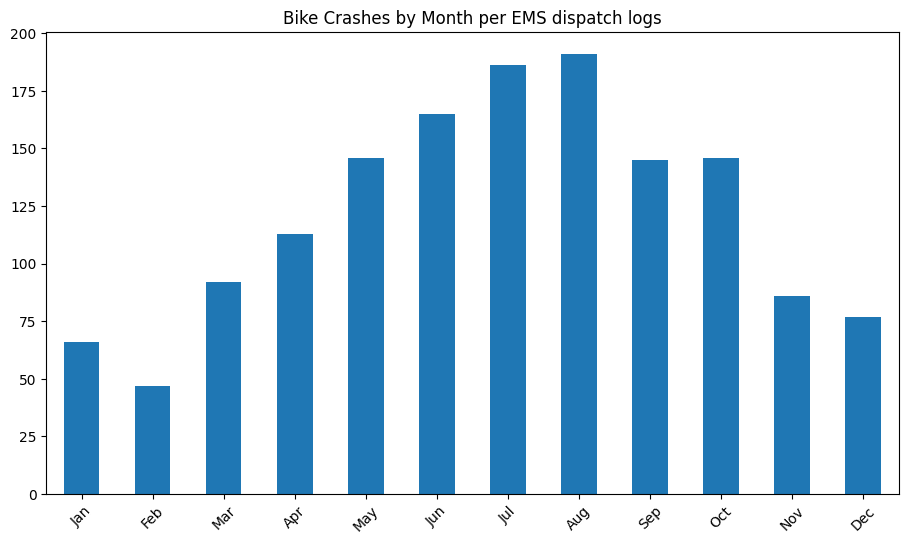

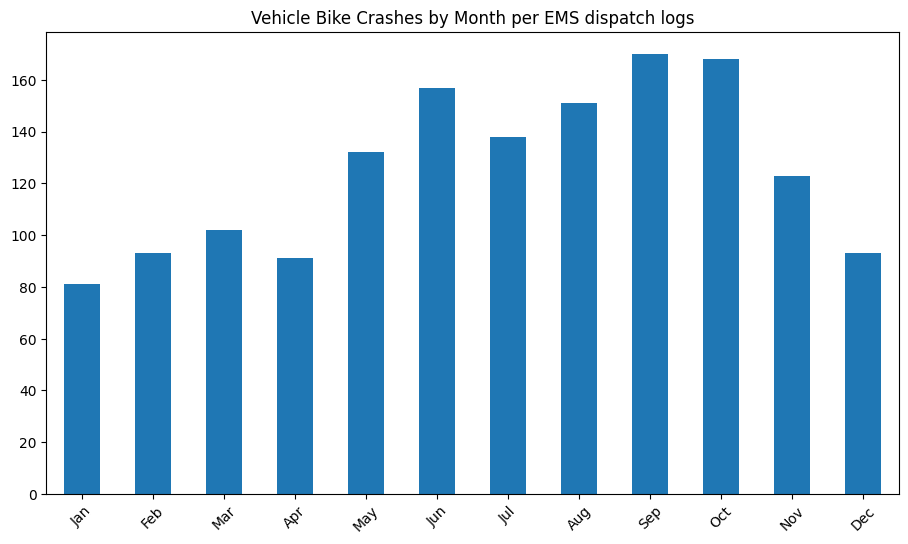

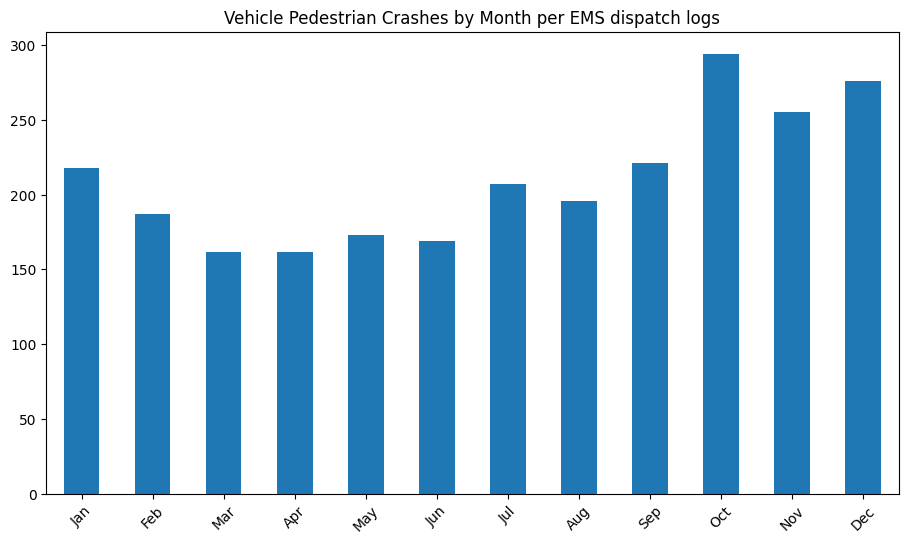

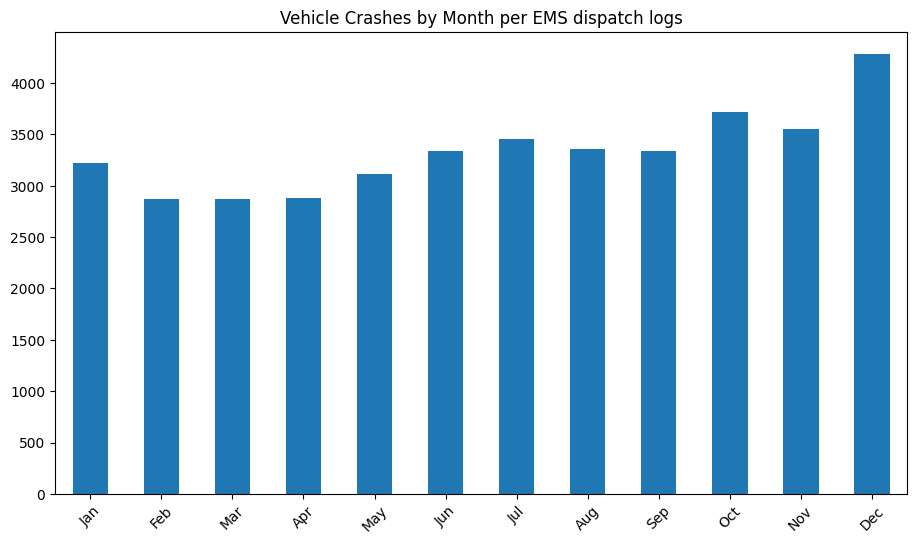

In [11]:
for agency, logs in agencies.items():
    for crash_type, df in logs.items():
        plot_crashes_per_time_unit(df, "month", agency=agency, title=crash_type, rot=45)

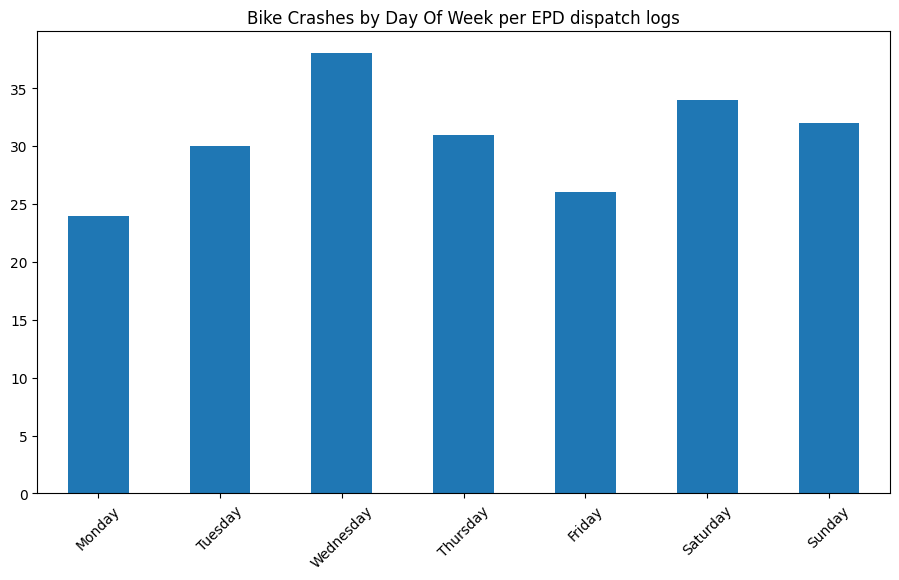

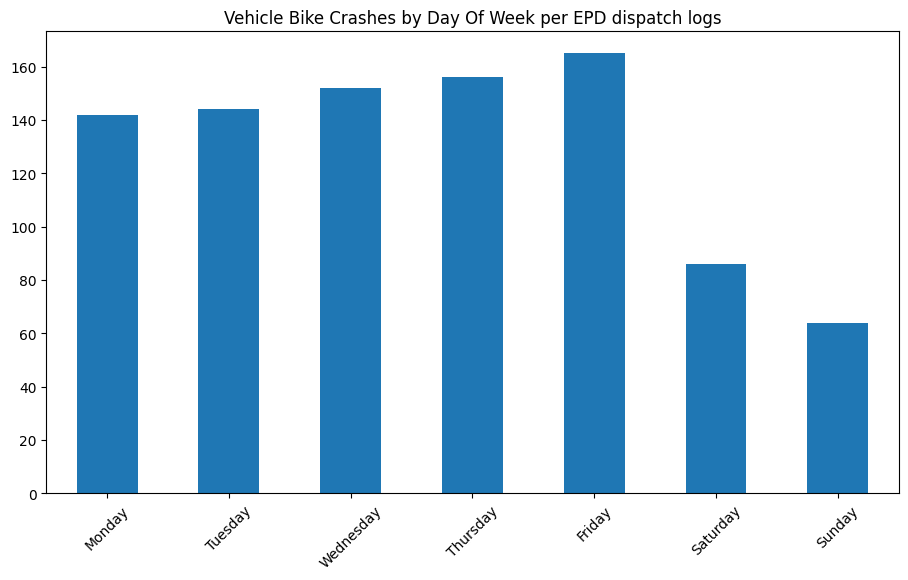

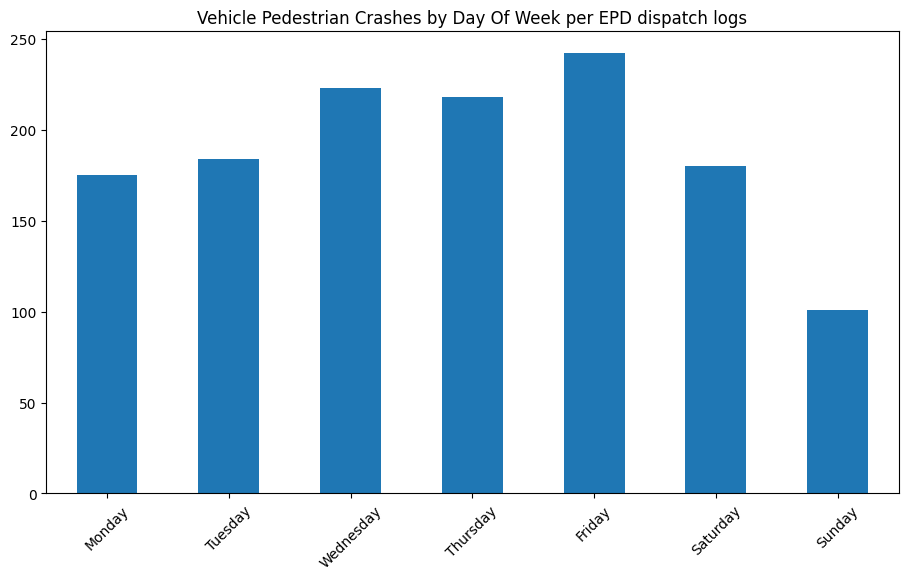

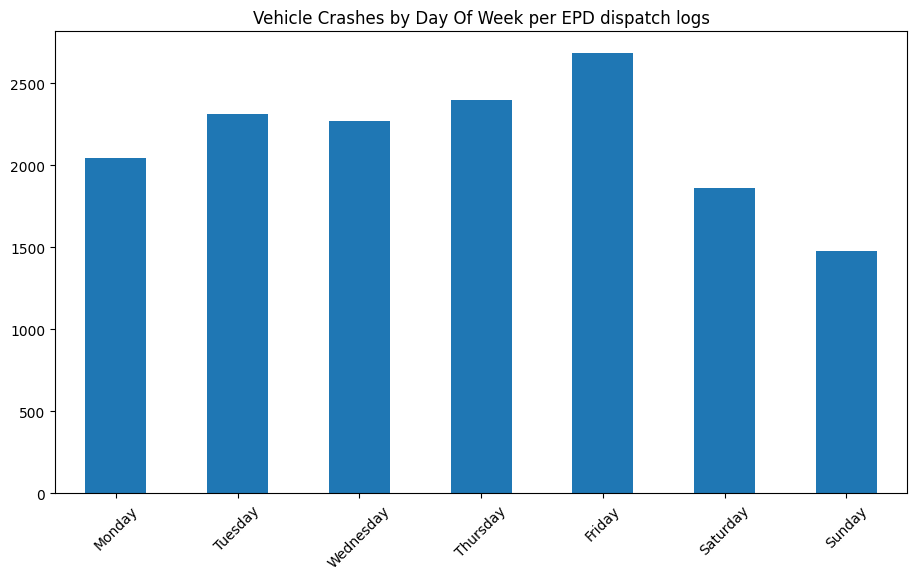

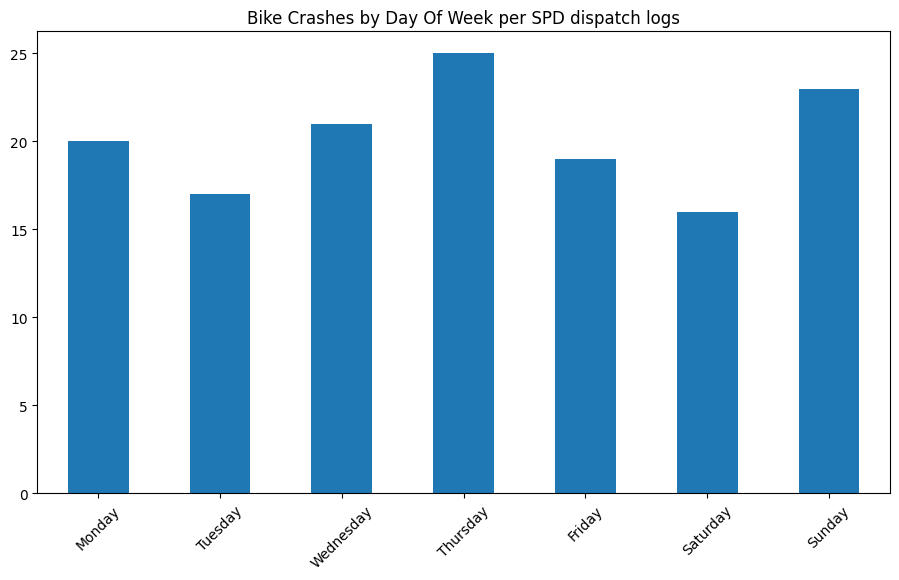

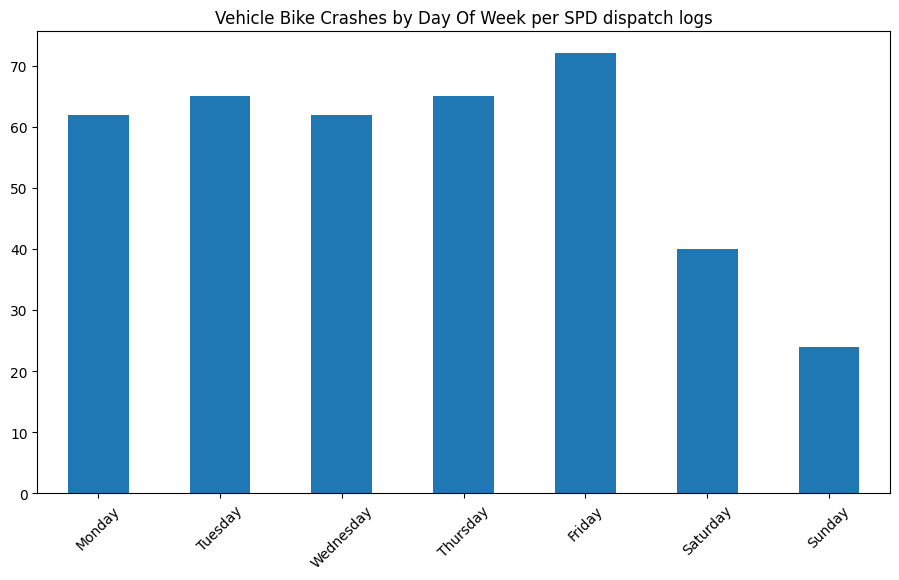

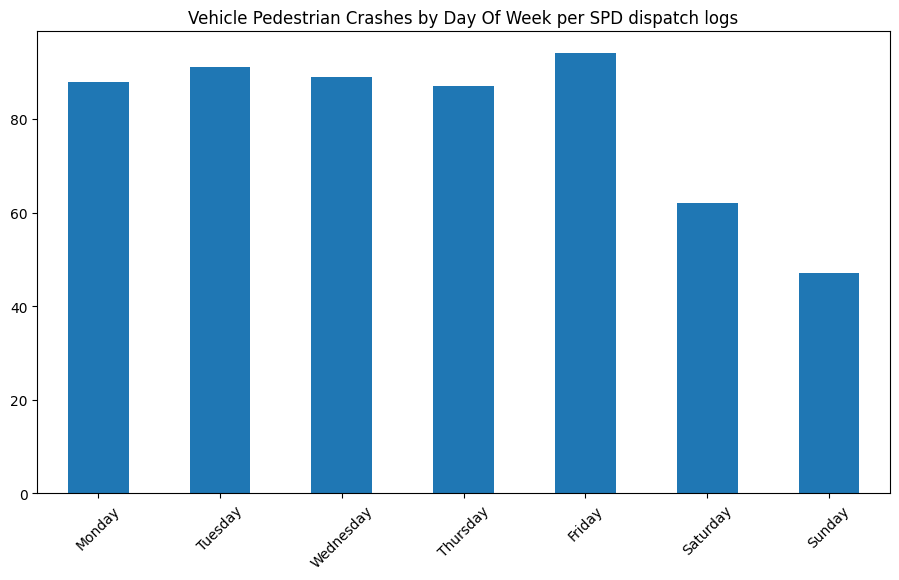

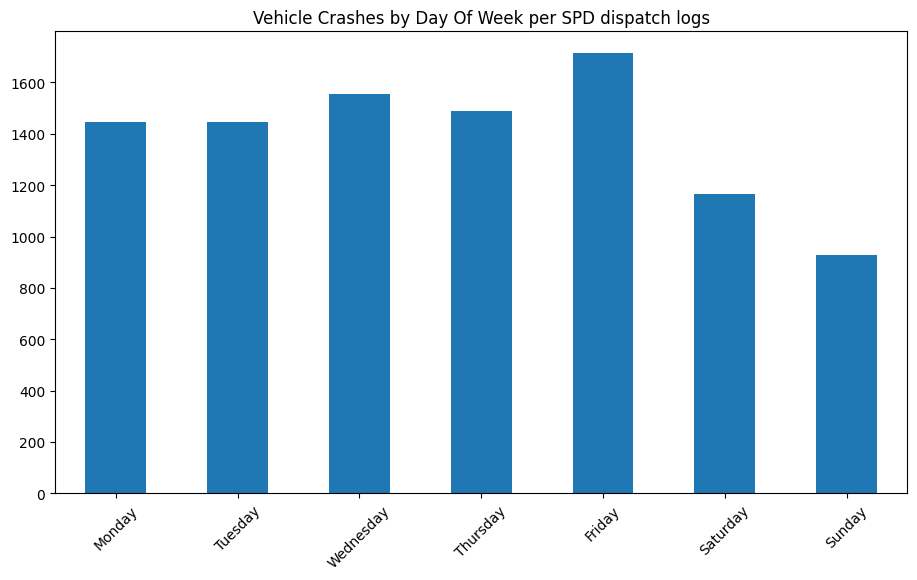

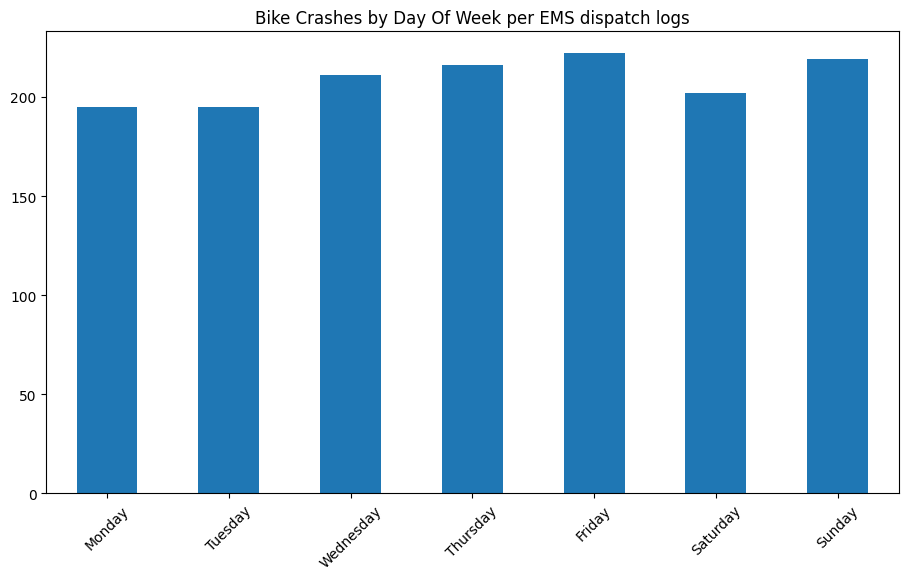

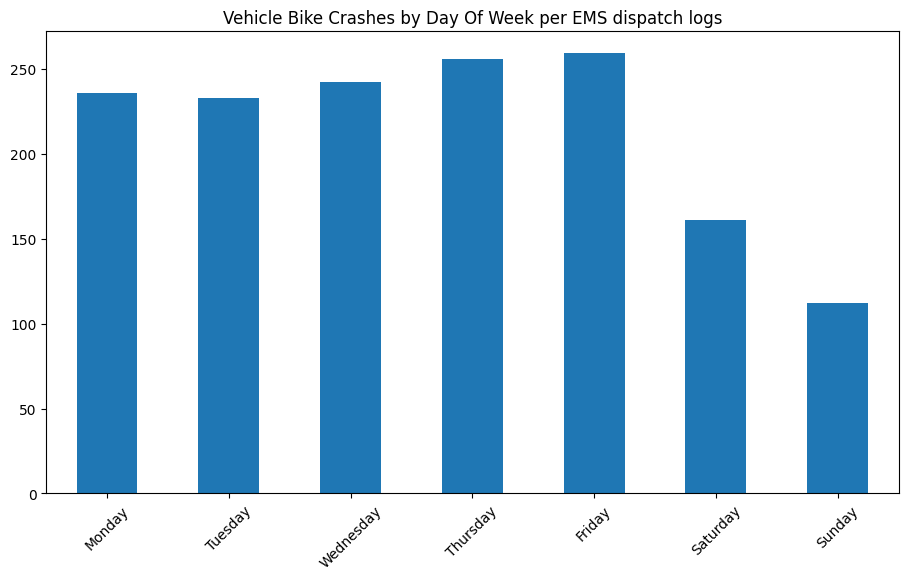

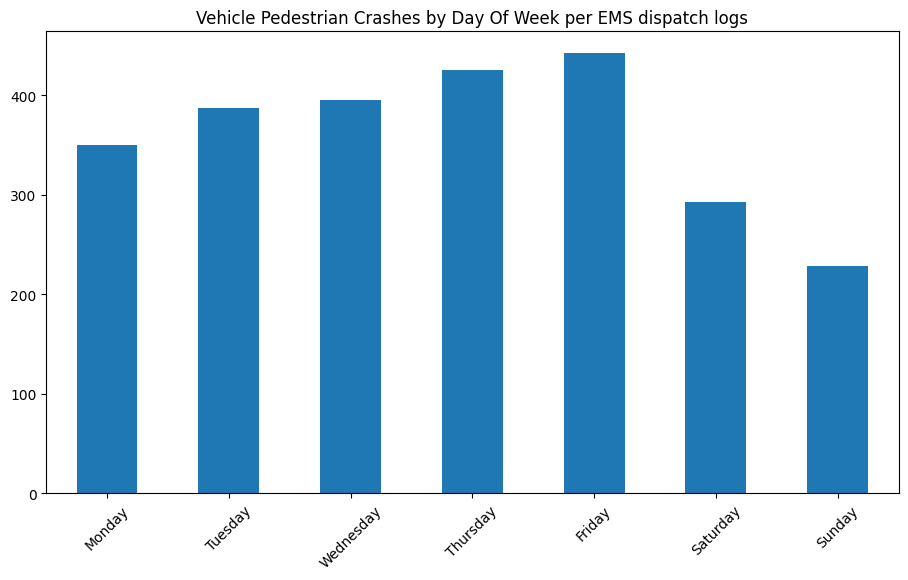

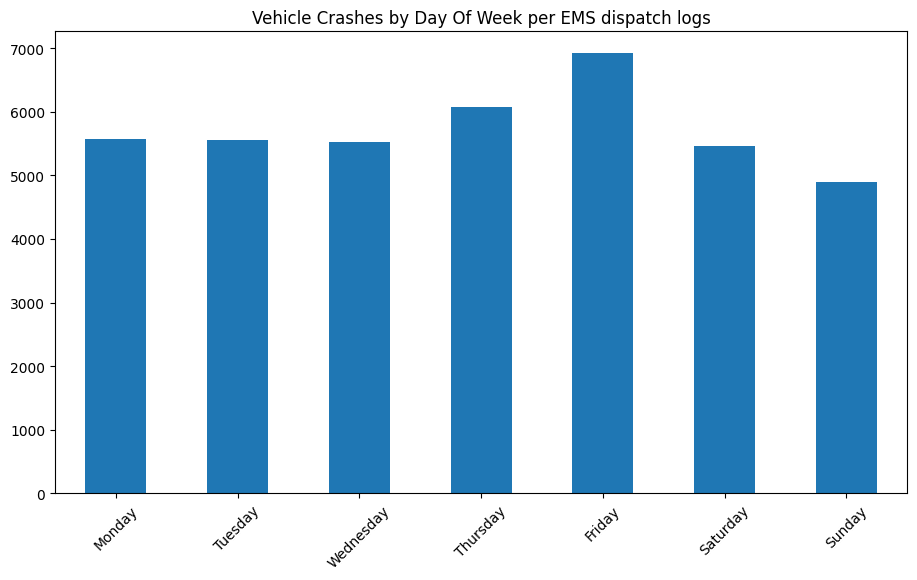

In [12]:
for agency, logs in agencies.items():
    for crash_type, df in logs.items():
        plot_crashes_per_time_unit(df, "day_of_week", agency=agency, title=crash_type, rot=45)

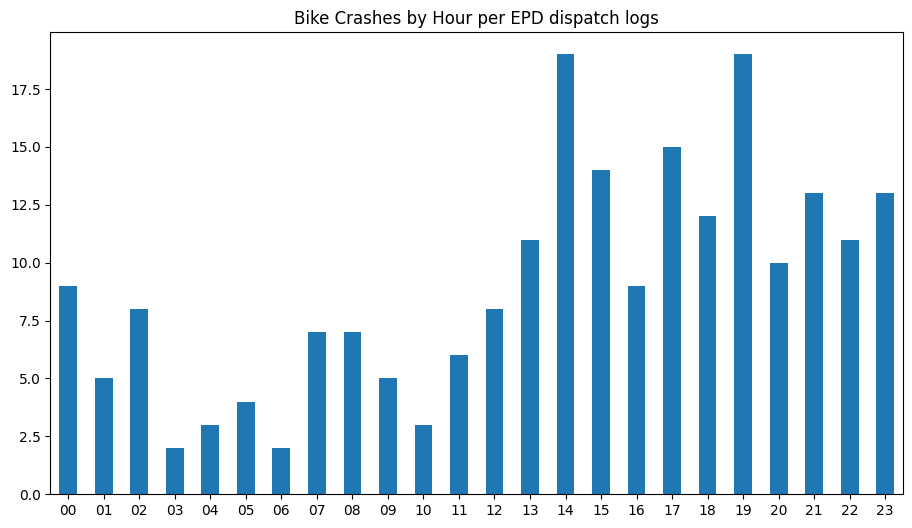

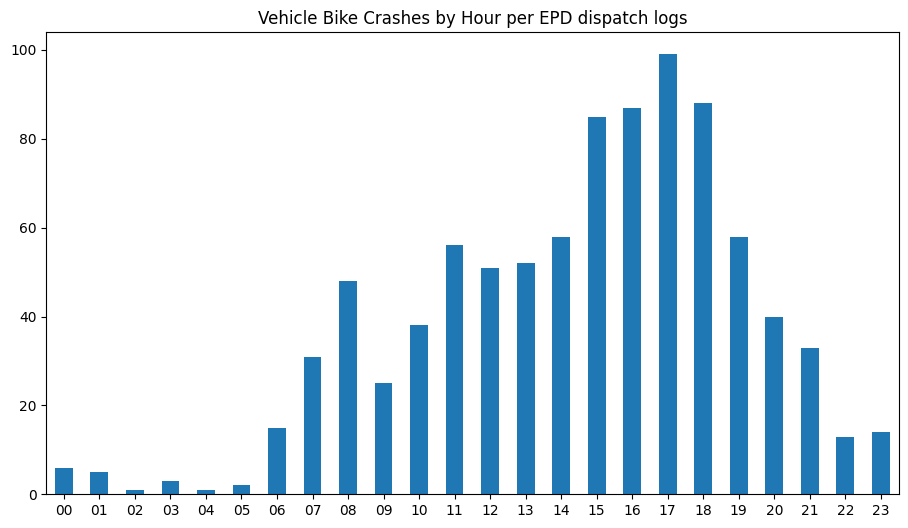

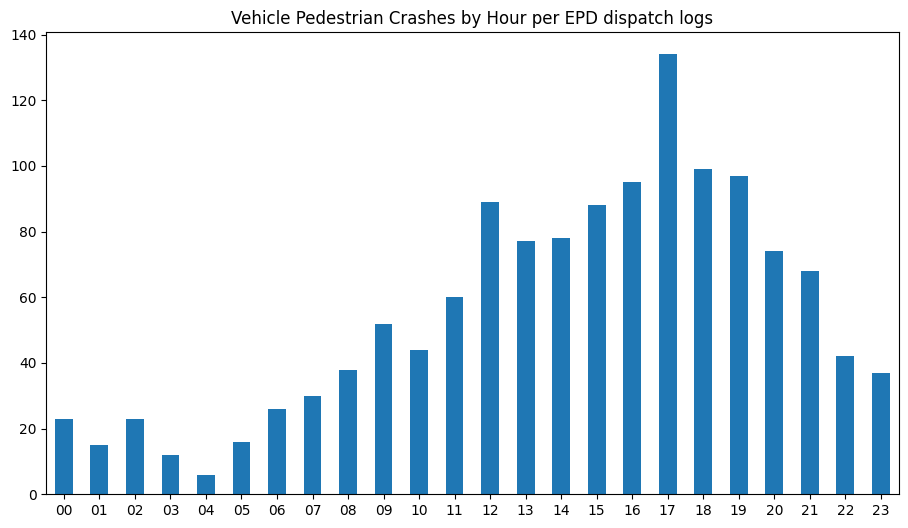

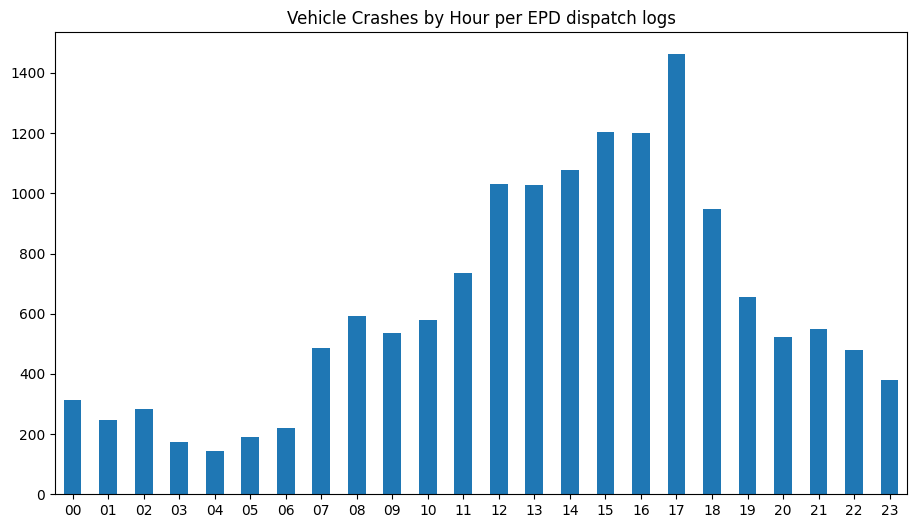

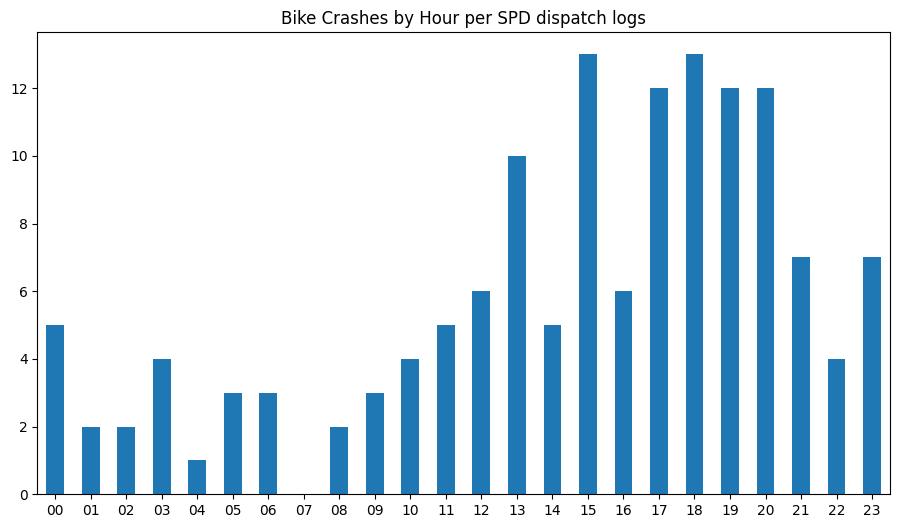

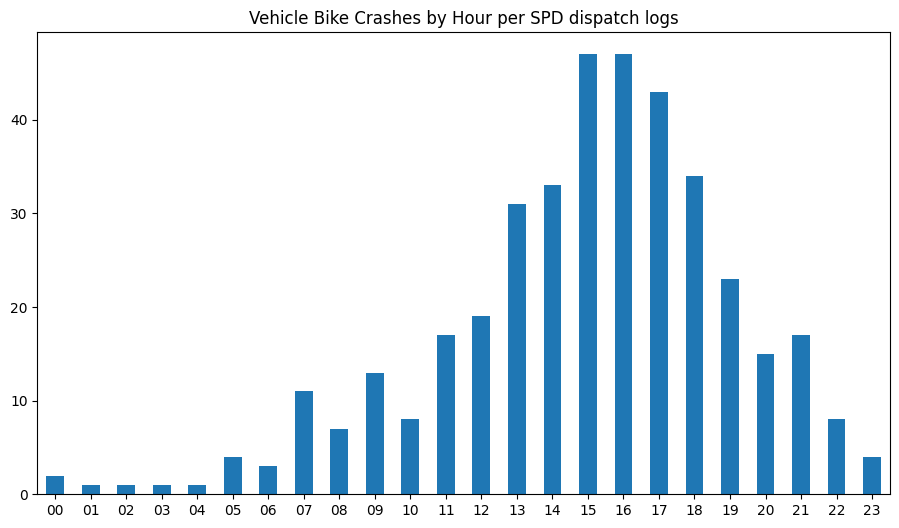

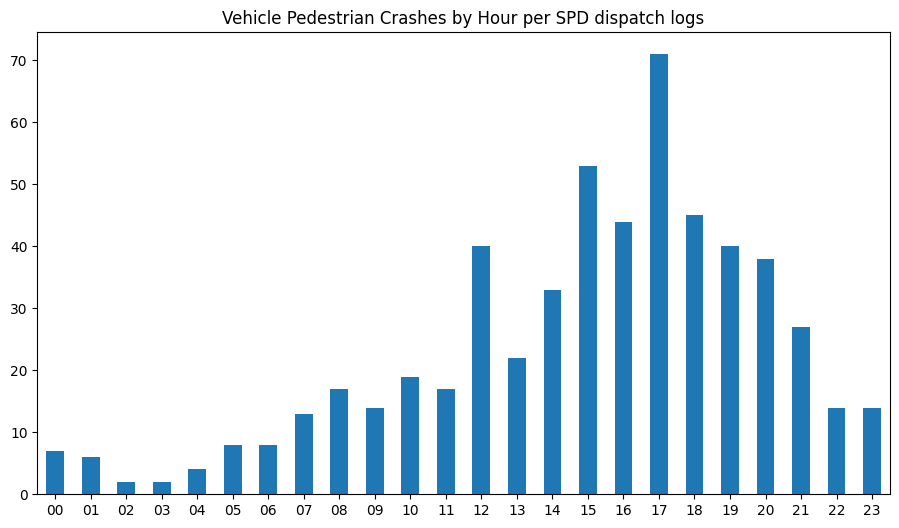

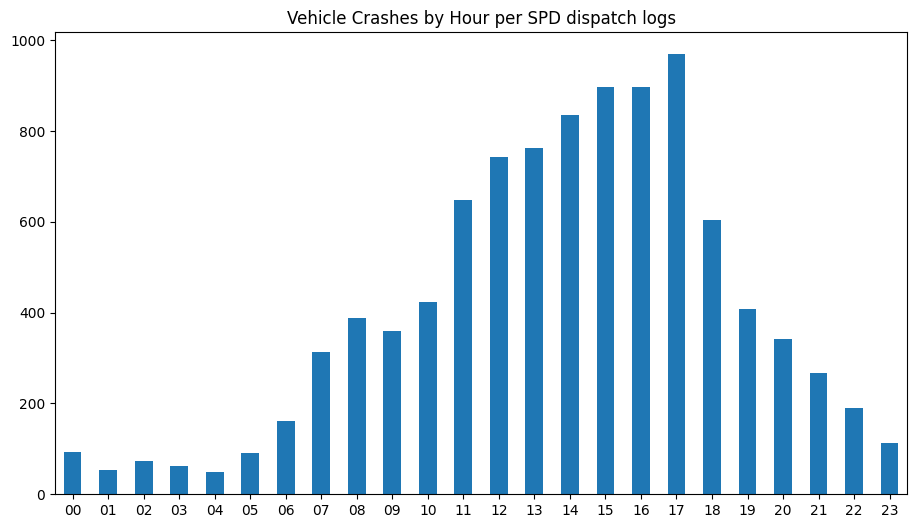

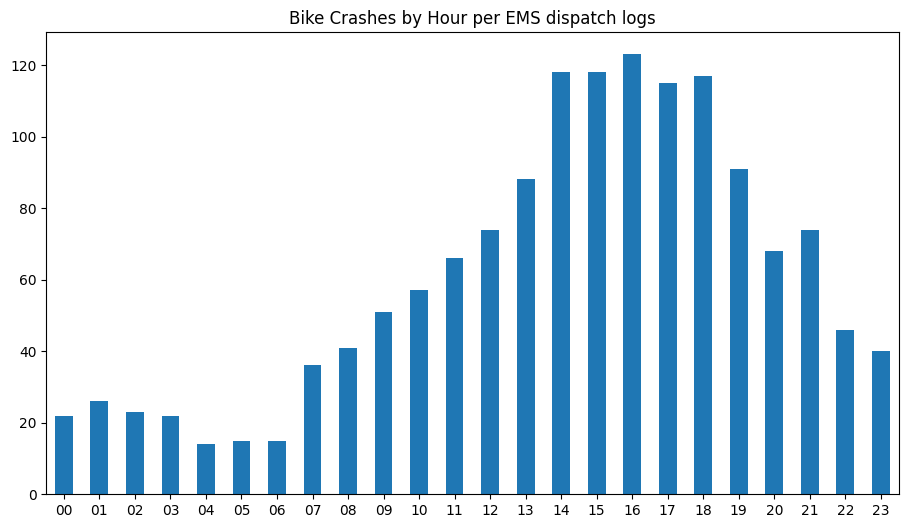

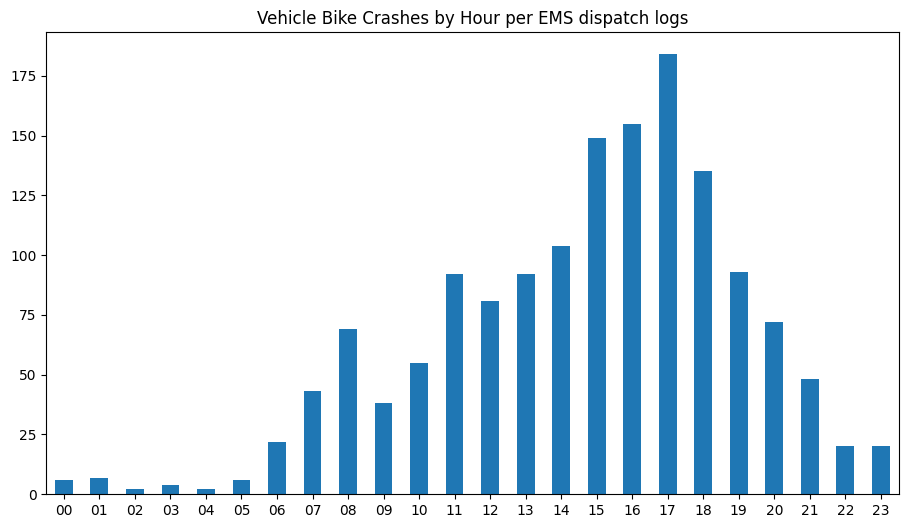

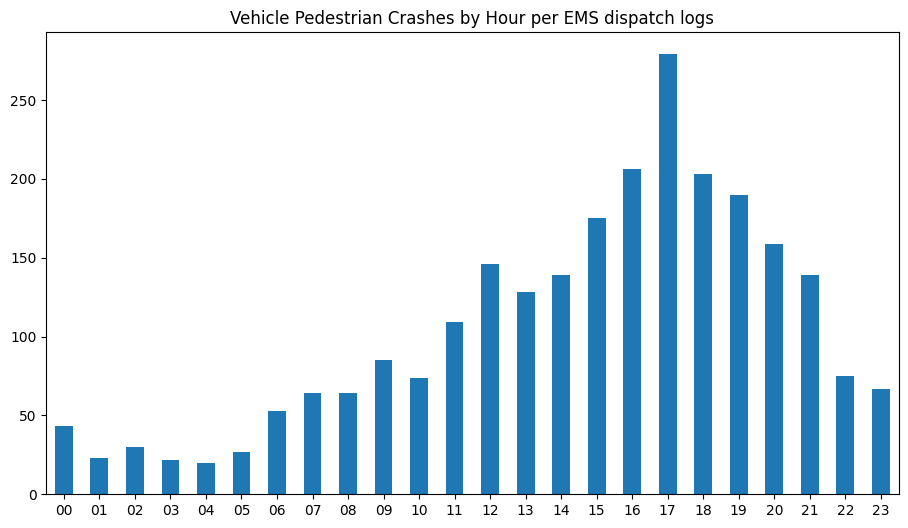

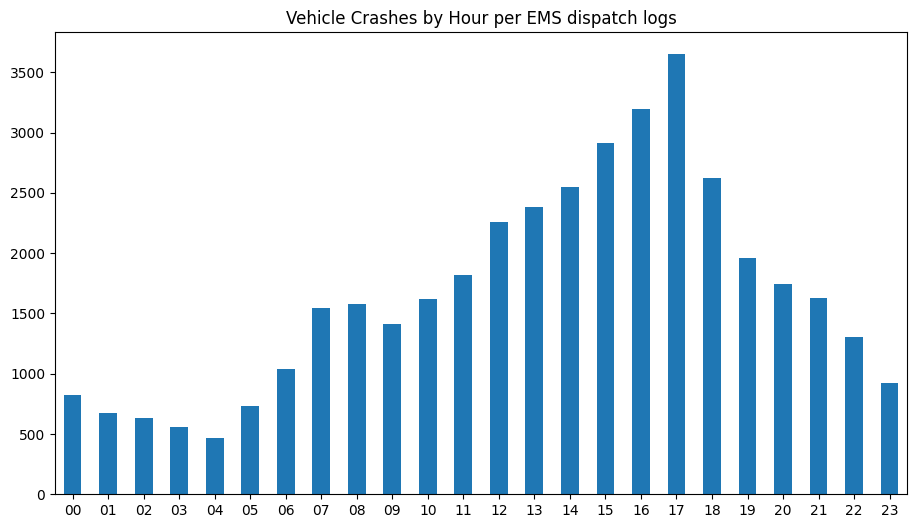

In [13]:
for agency, logs in agencies.items():
    for crash_type, df in logs.items():
        plot_crashes_per_time_unit(df, "hour", agency=agency, title=crash_type)

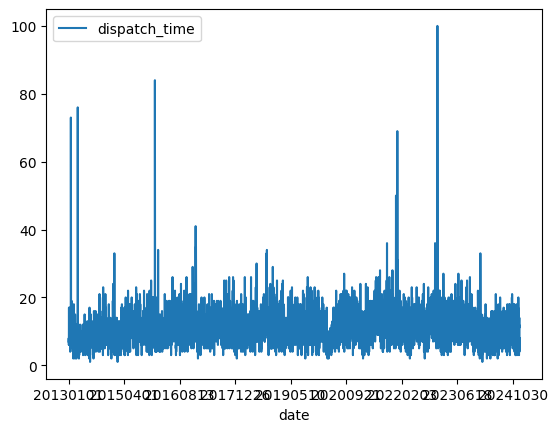

In [32]:
pivot = ems.pivot_table(
    index='date',
    values='dispatch_time',
    aggfunc='count'
)
pivot.plot(kind='line')
very_violent_days = pivot[pivot.dispatch_time >49]

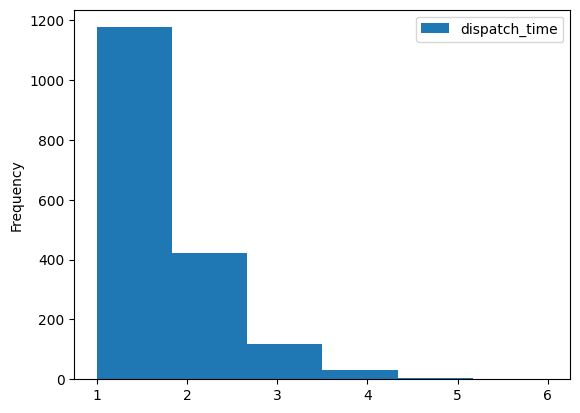

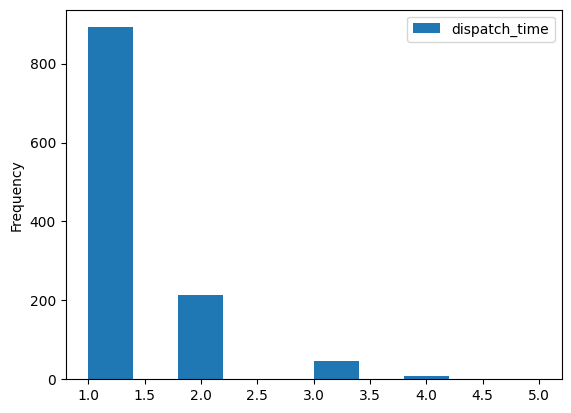

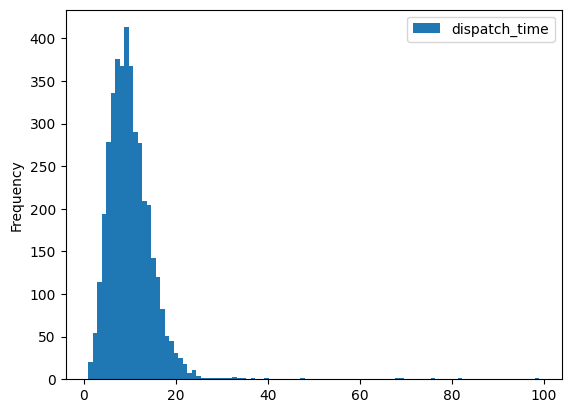

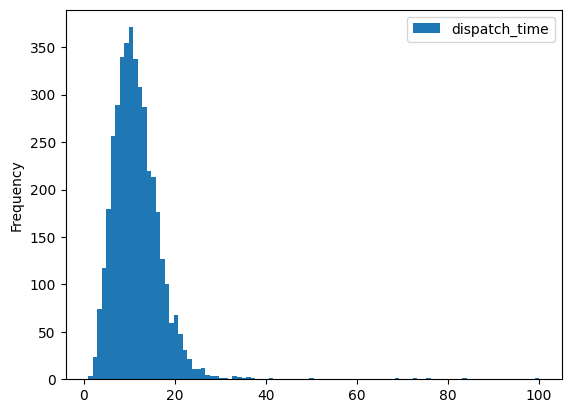

In [35]:
def hist_plot_by_time(df, index, **kwargs):
    pivot = df.pivot_table(
        index=index,
        values='dispatch_time',
        aggfunc='count'
    )
    pivot.plot.hist(**kwargs)
hist_plot_by_time(agencies['ems']['vehicle_pedestrian'], 'date', bins=6)
hist_plot_by_time(agencies['ems']['vehicle_bike'], 'date', bins=6)
hist_plot_by_time(agencies['ems']['vehicle'], 'date', bins=100)
hist_plot_by_time(ems, 'date', bins=100)

,dispatch_time
count,4063.000000
mean,11.232833
std,5.406830
min,1.000000
25%,8.000000
50%,11.000000
75%,14.000000
max,100.000000


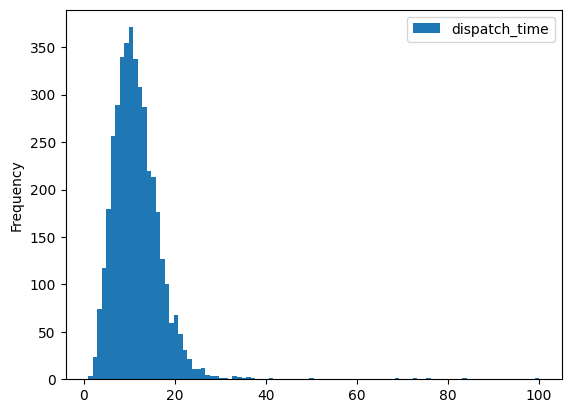

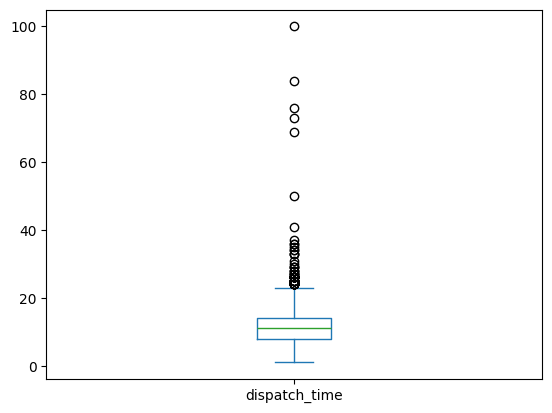

In [15]:
very_violent_days = pivot[pivot.dispatch_time >49]
pivot.plot.hist(bins=100)
pivot.plot.box()
pivot.describe()


In [19]:
for agency, logs in agencies.items():
    for crash_type, df in logs.items():
        mean = df.groupby('year').size().mean()
        print(f"{agency} {crash_type}: {len(df[df.year == '2024'])} vs mean {mean}")

        


epd bike: 30 vs mean 17.916666666666668
epd vehicle_bike: 89 vs mean 75.75
epd vehicle_pedestrian: 166 vs mean 110.25
epd vehicle: 1437 vs mean 1253.5
spd bike: 2 vs mean 8.8125
spd vehicle_bike: 22 vs mean 24.375
spd vehicle_pedestrian: 31 vs mean 34.875
spd vehicle: 710 vs mean 608.9375
ems bike: 174 vs mean 121.66666666666667
ems vehicle_bike: 140 vs mean 124.91666666666667
ems vehicle_pedestrian: 277 vs mean 210.0
ems vehicle: 3028 vs mean 3333.3333333333335


/tmp/ipykernel_61427/1633045081.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean = df.groupby('year').size().mean()
/tmp/ipykernel_61427/1633045081.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean = df.groupby('year').size().mean()
/tmp/ipykernel_61427/1633045081.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean = df.groupby('year').size().mean()
/tmp/ipykernel_61427/1633045081.py:3: FutureWarning:

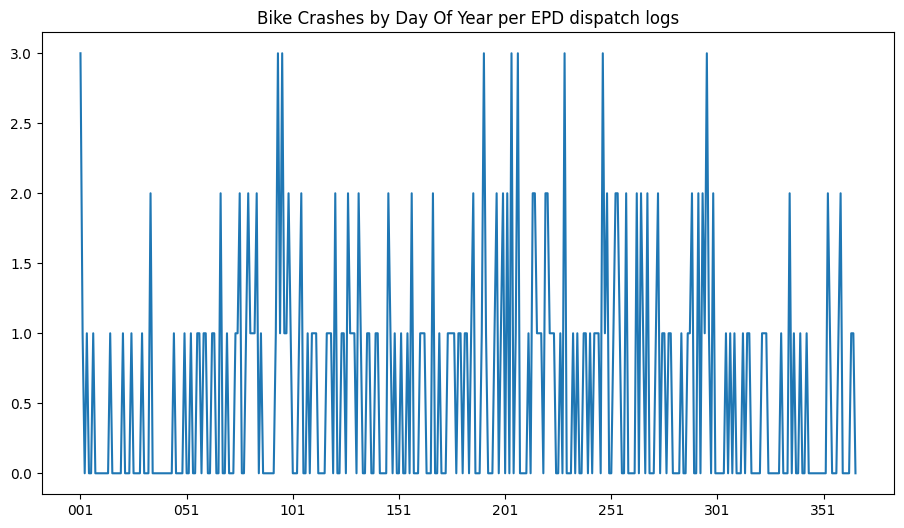

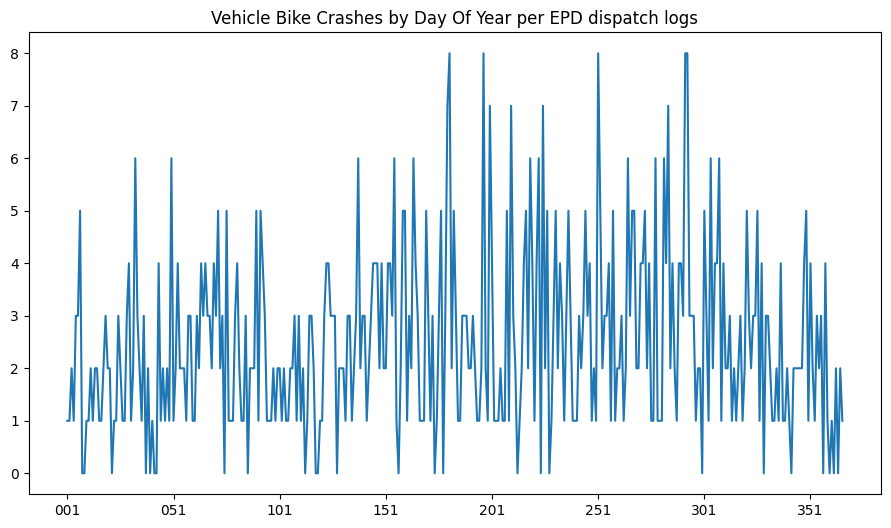

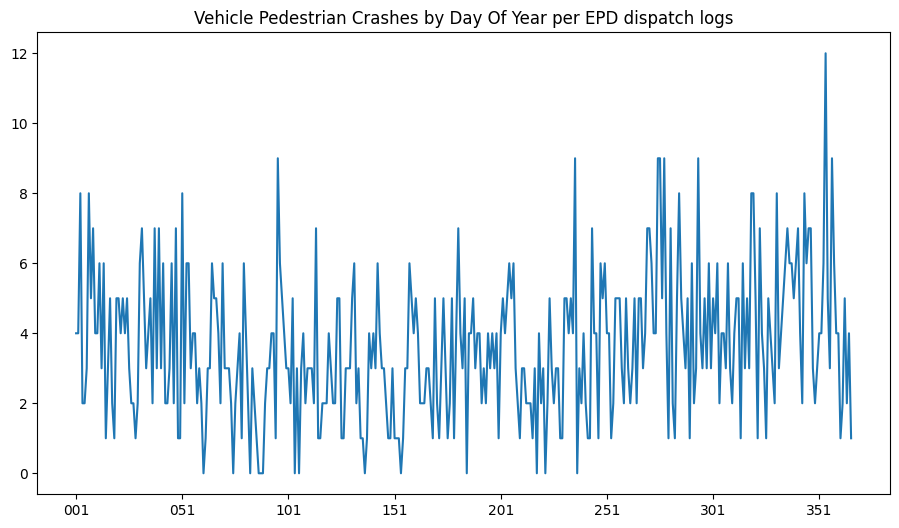

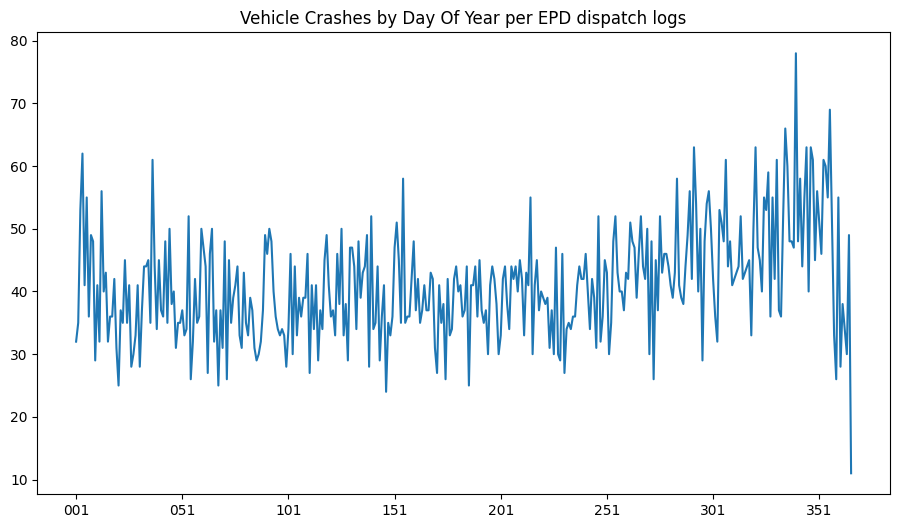

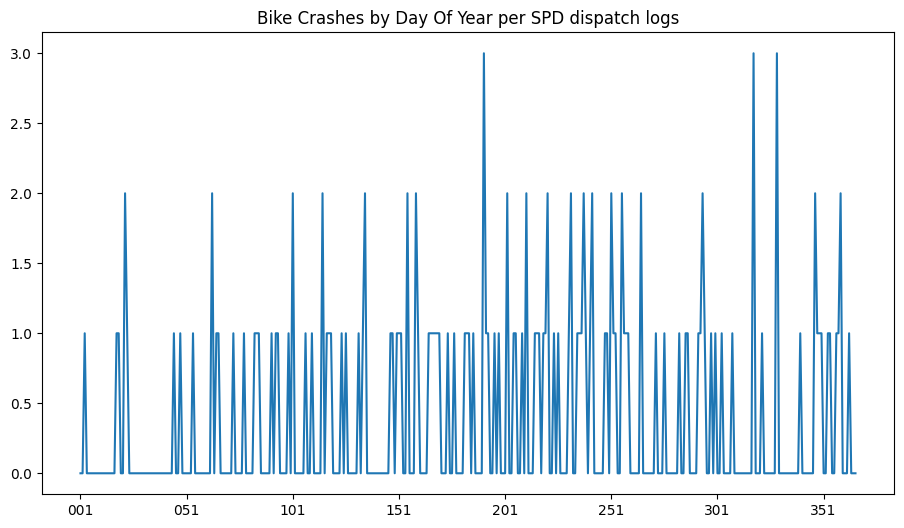

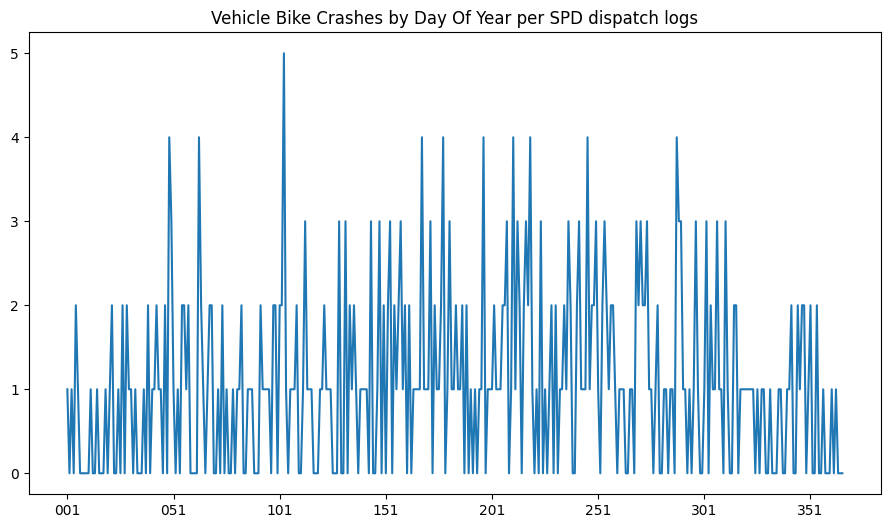

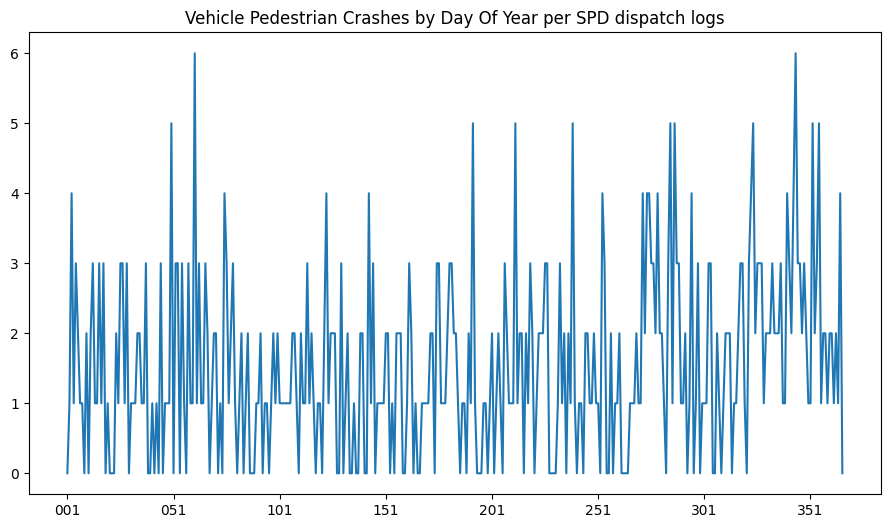

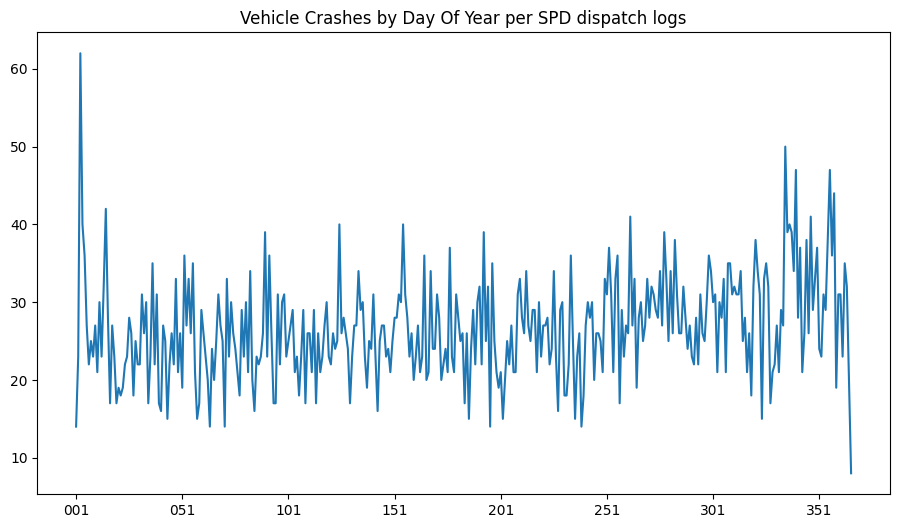

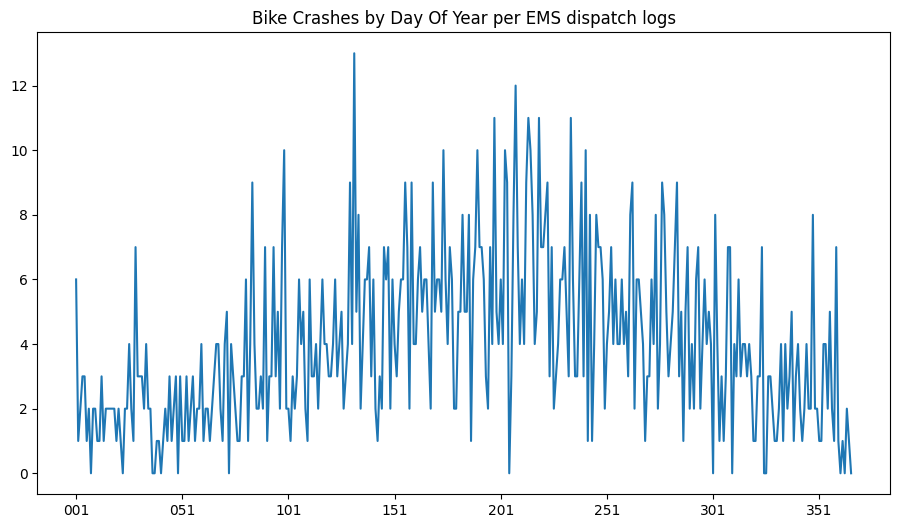

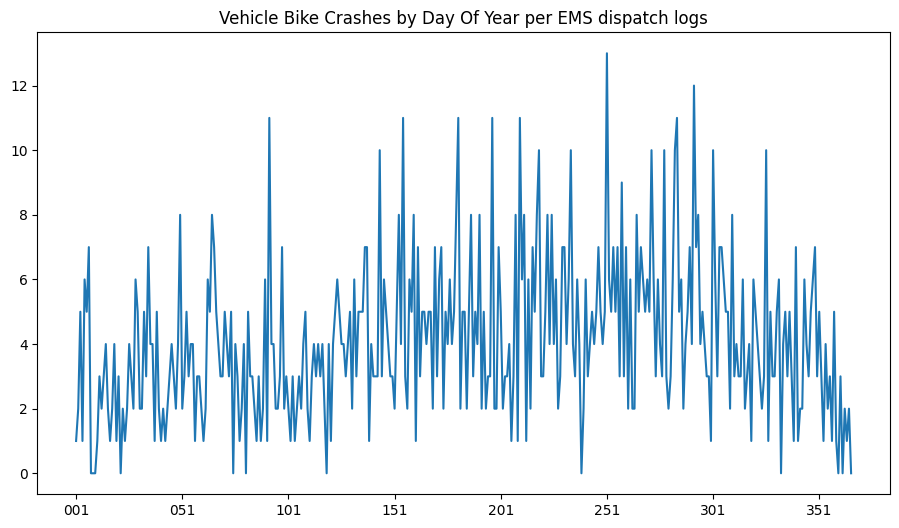

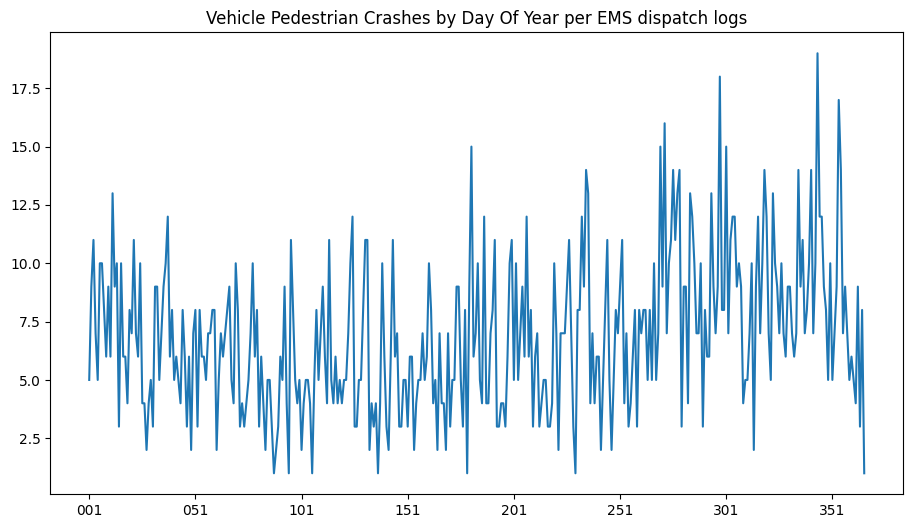

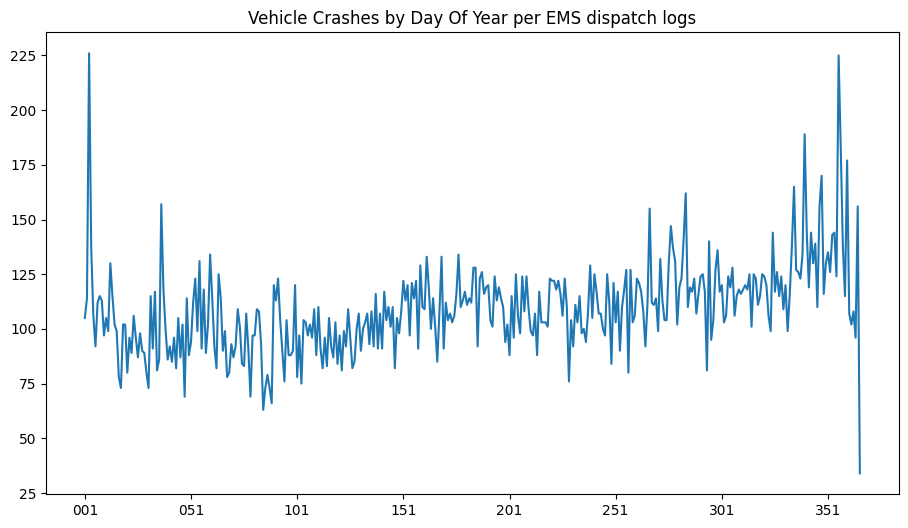

In [17]:
for agency, logs in agencies.items():
    for crash_type, df in logs.items():
        plot_crashes_per_time_unit(df, "day_of_year", agency=agency, title=crash_type, kind='line')